<h1 style="text-align:center;">Clustering Routes Final Attempt</h1>

<p style="text-align:center;">Vincent Etherton -- SML312: Research Projects in Data Science</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trimmed_weeks = []

for i in range(8):
    df = pd.read_csv(f'./data/week_{i}_trimmed.csv')
    trimmed_weeks.append(df)

trimmed_weeks[0].head()

,Unnamed: 0,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,0,2021090900,97,41233.0,6,2021-09-10T00:26:31.600,13.0,TB,right,0.00,0.00,0.00,0.00,0.00,129.28,4.76,ball_snap
1,1,2021090900,97,41233.0,7,2021-09-10T00:26:31.700,13.0,TB,right,0.01,0.01,0.00,0.00,0.01,129.28,23.29,NaN
2,2,2021090900,97,41233.0,8,2021-09-10T00:26:31.800,13.0,TB,right,0.02,0.02,0.02,0.55,0.01,127.86,41.24,NaN
3,3,2021090900,97,41233.0,9,2021-09-10T00:26:31.900,13.0,TB,right,0.04,0.03,0.27,2.93,0.02,125.97,61.85,NaN
4,4,2021090900,97,41233.0,10,2021-09-10T00:26:32.000,13.0,TB,right,0.08,0.05,0.64,3.88,0.04,125.17,61.07,NaN


In [3]:
for idx, df in enumerate(trimmed_weeks):
    df.drop(columns='Unnamed: 0', inplace=True)

trimmed_weeks[0].head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,41233.0,6,2021-09-10T00:26:31.600,13.0,TB,right,0.00,0.00,0.00,0.00,0.00,129.28,4.76,ball_snap
1,2021090900,97,41233.0,7,2021-09-10T00:26:31.700,13.0,TB,right,0.01,0.01,0.00,0.00,0.01,129.28,23.29,NaN
2,2021090900,97,41233.0,8,2021-09-10T00:26:31.800,13.0,TB,right,0.02,0.02,0.02,0.55,0.01,127.86,41.24,NaN
3,2021090900,97,41233.0,9,2021-09-10T00:26:31.900,13.0,TB,right,0.04,0.03,0.27,2.93,0.02,125.97,61.85,NaN
4,2021090900,97,41233.0,10,2021-09-10T00:26:32.000,13.0,TB,right,0.08,0.05,0.64,3.88,0.04,125.17,61.07,NaN


In [4]:
combined_df = pd.concat(trimmed_weeks[:-2], axis=0, ignore_index=True)

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684037 entries, 0 to 684036
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   gameId         684037 non-null  int64  
 1   playId         684037 non-null  int64  
 2   nflId          684037 non-null  float64
 3   frameId        684037 non-null  int64  
 4   time           684037 non-null  object 
 5   jerseyNumber   684037 non-null  float64
 6   team           684037 non-null  object 
 7   playDirection  684037 non-null  object 
 8   x              684037 non-null  float64
 9   y              684037 non-null  float64
 10  s              684037 non-null  float64
 11  a              684037 non-null  float64
 12  dis            684037 non-null  float64
 13  o              684037 non-null  float64
 14  dir            684037 non-null  float64
 15  event          66348 non-null   object 
dtypes: float64(9), int64(3), object(4)
memory usage: 83.5+ MB


We'll leverage the same Bezier curves library and we'll use 8 control points defining the curves. We will use 50 equally spaced sample points from the curves, but we could probably experiment with using lower-dimensional data in the future.

In [5]:
import bezier

n_control_points = 8
num_points = 50

def calc_bezier(df):
    x = np.array(df.x)
    y = np.array(df.y)

    indices = np.linspace(0, len(x) - 1, n_control_points, dtype=int)
    x_down = x[indices]
    y_down = y[indices]

    points_down = np.array([x_down, y_down])

    curve = bezier.Curve.from_nodes(points_down)

    s_vals = np.linspace(0.0, 1.0, num_points)
    curve_points = curve.evaluate_multi(s_vals)

    interleaved_points = np.empty(curve_points.size, dtype=curve_points.dtype)
    interleaved_points[0::2] = curve_points[0]  # x-coordinates
    interleaved_points[1::2] = curve_points[1]  # y-coordinates
    
    return interleaved_points

In [6]:
routes_with_plays = []
for (gameId, playId, nflId), play_data in combined_df.groupby(['gameId', 'playId', 'nflId']):
    bezier_curve = calc_bezier(play_data)
    routes_with_plays.append({
        'gameId': gameId,
        'playId': playId,
        'nflId': nflId,
        'bezier_curve': bezier_curve
    })

# Convert to DataFrame
routes_df = pd.DataFrame(routes_with_plays)

routes_df.head()

,gameId,playId,nflId,bezier_curve
0,2021090900,97,35481.0,"[0.0, -0.0, 0.10591385392385956, -0.0864401776..."
1,2021090900,97,35634.0,"[0.0, -0.0, 0.11257039761130107, -0.0940826796..."
2,2021090900,97,39985.0,"[0.0, 0.0, 0.016995940210599105, 0.01983417802..."
3,2021090900,97,41233.0,"[0.0, 0.0, 0.03139033275379332, 0.018729531964..."
4,2021090900,97,44896.0,"[0.0, 0.0, 0.11400586146724184, 0.169068676925..."


We want to add another feature to the clustering to allow for more accurate groupings. Let's look at final position of the route in question as this could give an indicator for depth of the route.

In [7]:
def calculate_final_position_efficient(combined_df, routes_df):
    final_positions = combined_df.groupby(['gameId', 'playId', 'nflId']).apply(
        lambda df: (df['x'].iloc[-1], df['y'].iloc[-1])
    ).reset_index(name='final_pos')
    
    routes_df = routes_df.merge(
        final_positions,
        on=['gameId', 'playId', 'nflId'],
        how='left'
    )
    
    return routes_df

routes_df = calculate_final_position_efficient(combined_df, routes_df)

routes_df.head()

/var/folders/94/k_n9_k290dq3fhrtlyvj38qh0000gn/T/ipykernel_7818/282123589.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_positions = combined_df.groupby(['gameId', 'playId', 'nflId']).apply(


,gameId,playId,nflId,bezier_curve,final_pos
0,2021090900,97,35481.0,"[0.0, -0.0, 0.10591385392385956, -0.0864401776...","(5.840000000000003, -16.37)"
1,2021090900,97,35634.0,"[0.0, -0.0, 0.11257039761130107, -0.0940826796...","(14.009999999999998, -3.629999999999995)"
2,2021090900,97,39985.0,"[0.0, 0.0, 0.016995940210599105, 0.01983417802...","(0.7100000000000009, -8.12)"
3,2021090900,97,41233.0,"[0.0, 0.0, 0.03139033275379332, 0.018729531964...","(4.910000000000004, 16.790000000000003)"
4,2021090900,97,44896.0,"[0.0, 0.0, 0.11400586146724184, 0.169068676925...","(13.990000000000002, 14.600000000000003)"


In [11]:
from sklearn.model_selection import train_test_split

curves = np.array(routes_df['bezier_curve'].tolist())
train_idx, test_idx = train_test_split(
    np.arange(len(curves)), test_size=0.2, random_state=0
)

routes_df['train_test_split'] = 'train'
routes_df.loc[test_idx, 'train_test_split'] = 'test'

In [12]:
from sklearn.preprocessing import StandardScaler

curves = np.array(routes_df['bezier_curve'].tolist()) 
final_positions = np.array(routes_df['final_pos'].tolist()) 

In [16]:
from sklearn.cluster import KMeans

train_curves = curves[train_idx]
test_curves = curves[test_idx]
train_positions = final_positions[train_idx]
test_positions = final_positions[test_idx]

scaler_curves = StandardScaler()
scaler_positions = StandardScaler()

scaled_train_curves = scaler_curves.fit_transform(train_curves)
scaled_test_curves = scaler_curves.transform(test_curves)  # Use the same scaler
scaled_train_positions = scaler_positions.fit_transform(train_positions)
scaled_test_positions = scaler_positions.transform(test_positions)

kmeans_curves = KMeans(n_clusters=10, random_state=0).fit(scaled_train_curves)
kmeans_positions = KMeans(n_clusters=10, random_state=0).fit(scaled_train_positions)

routes_df.loc[train_idx, 'curve_cluster'] = kmeans_curves.labels_
routes_df.loc[test_idx, 'curve_cluster'] = kmeans_curves.predict(scaled_test_curves)

routes_df.loc[train_idx, 'position_cluster'] = kmeans_positions.labels_
routes_df.loc[test_idx, 'position_cluster'] = kmeans_positions.predict(scaled_test_positions)

routes_df['cluster_label'] = (
    routes_df['curve_cluster'].astype(str) + "_" + routes_df['position_cluster'].astype(str)
)

train_data = routes_df[routes_df['train_test_split'] == 'train']
test_data = routes_df[routes_df['train_test_split'] == 'test']

print(len(routes_df['cluster_label'].unique()))

67


In [14]:
from sklearn.metrics import silhouette_score

train_sil = silhouette_score(scaled_train_curves, kmeans_curves.predict(scaled_train_curves))
test_sil = silhouette_score(scaled_test_curves, kmeans_curves.predict(scaled_test_curves))

train_sil2 = silhouette_score(scaled_train_positions, kmeans_positions.predict(scaled_train_positions))
test_sil2 = silhouette_score(scaled_test_positions, kmeans_positions.predict(scaled_test_positions))

print(train_sil)
print(test_sil)
print(train_sil2)
print(test_sil2)

0.2595501669718864
0.25378239804078134
0.3329701205707667
0.3308093693144723


The Silhouette Scores for the two models are around 0.25 and 0.33 respectively. This is considerable improvement from when we solely used the Bezier curves as features. 

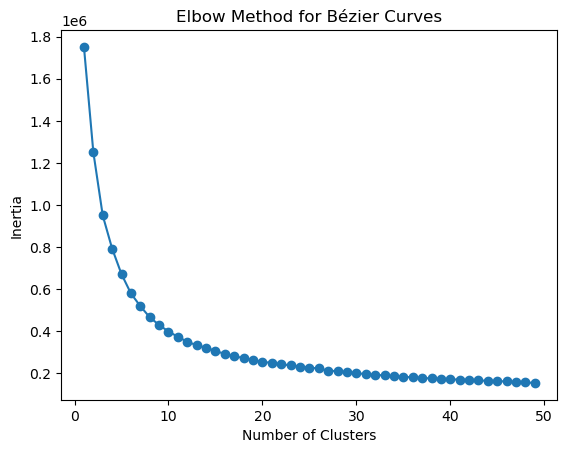

In [15]:
range_n_clusters = range(1, 50)

inertia_curves = []
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_train_curves)
    inertia_curves.append(kmeans.inertia_)

plt.plot(range_n_clusters, inertia_curves, marker='o')
plt.title('Elbow Method for Bézier Curves')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

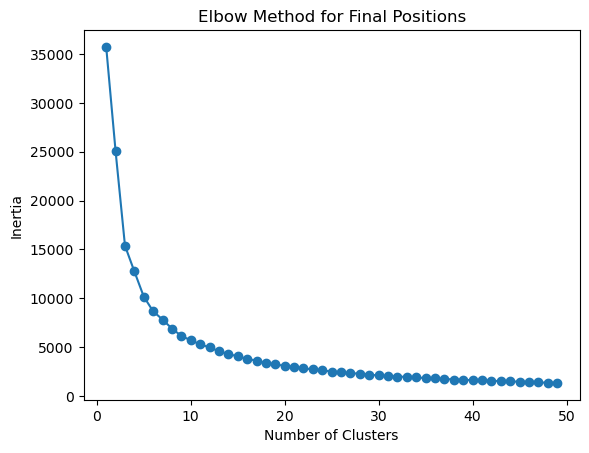

In [17]:
range_n_clusters = range(1, 50)

inertia_curves = []
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_train_positions)
    inertia_curves.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range_n_clusters, inertia_curves, marker='o')
plt.title('Elbow Method for Final Positions')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

These plots illustrate using the elbow method for determining the number of clusters for each model according to the inertia curve of the k-means cluster model.

In [74]:
combined_df = combined_df.merge(
    routes_df[['gameId', 'playId', 'nflId', 'cluster_label', 'train_test_split']],
    on=['gameId', 'playId', 'nflId'],
    how='left'
)

combined_df.head(10)

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,cluster_label,train_test_split
0,2021090900,97,41233.0,6,2021-09-10T00:26:31.600,13.0,TB,right,0.00,0.00,0.00,0.00,0.00,129.28,4.76,ball_snap,7.0_4.0,train
1,2021090900,97,41233.0,7,2021-09-10T00:26:31.700,13.0,TB,right,0.01,0.01,0.00,0.00,0.01,129.28,23.29,NaN,7.0_4.0,train
2,2021090900,97,41233.0,8,2021-09-10T00:26:31.800,13.0,TB,right,0.02,0.02,0.02,0.55,0.01,127.86,41.24,NaN,7.0_4.0,train
3,2021090900,97,41233.0,9,2021-09-10T00:26:31.900,13.0,TB,right,0.04,0.03,0.27,2.93,0.02,125.97,61.85,NaN,7.0_4.0,train
4,2021090900,97,41233.0,10,2021-09-10T00:26:32.000,13.0,TB,right,0.08,0.05,0.64,3.88,0.04,125.17,61.07,NaN,7.0_4.0,train
5,2021090900,97,41233.0,11,2021-09-10T00:26:32.100,13.0,TB,right,0.16,0.09,1.11,4.22,0.09,123.72,61.91,NaN,7.0_4.0,train
6,2021090900,97,41233.0,12,2021-09-10T00:26:32.200,13.0,TB,right,0.29,0.16,1.63,4.35,0.15,122.60,63.15,NaN,7.0_4.0,train
7,2021090900,97,41233.0,13,2021-09-10T00:26:32.300,13.0,TB,right,0.48,0.26,2.28,4.73,0.22,120.24,62.43,NaN,7.0_4.0,train
8,2021090900,97,41233.0,14,2021-09-10T00:26:32.400,13.0,TB,right,0.72,0.41,2.92,4.87,0.28,115.86,59.70,NaN,7.0_4.0,train
9,2021090900,97,41233.0,15,2021-09-10T00:26:32.500,13.0,TB,right,1.00,0.60,3.49,4.56,0.34,110.40,57.90,NaN,7.0_4.0,train


We can uncomment the following code to plot the testing and training clusters. This method was used in conjunction with the cluster medians to determine what route the cluster was representing.

In [19]:
# testing = combined_df[combined_df['train_test_split'] == 'train']

# unique_plays = combined_df[['gameId', 'playId']].drop_duplicates()

# for cluster_label, cluster_data in testing.groupby('cluster_label'):
#     plt.figure(figsize=(10, 6))
    
#     # Filter plays and players within this cluster
#     plt.title(f"Routes for Cluster: {cluster_label}")
#     plt.xlabel('X Coordinate')
#     plt.ylabel('Y Coordinate')
    
#     for (gameId, playId, nflId), play_data in cluster_data.groupby(['gameId', 'playId', 'nflId']):
#         # Define play start and end
#         play_start = play_data[play_data['event'] == 'ball_snap']['frameId']
#         play_end = play_data[play_data['event'].isin(['pass_arrived', 'qb_strip_sack', 'qb_sack', 'pass_tipped'])]['frameId']
        
#         if play_end.empty:
#             play_end = play_data[play_data['event'].isin(['pass_forward'])]['frameId']
        
#         if not play_start.empty and not play_end.empty:
#             play_start = play_start.iloc[0]
#             play_end = play_end.iloc[0]
            
#             # Filter route data based on frame range
#             route_data = play_data[(play_data['frameId'] >= play_start) & (play_data['frameId'] <= play_end)]
            
#             # Plot routes for players in this play
#             for player_id, player_data in route_data.groupby('jerseyNumber'):
#                 plt.plot(player_data['x'], player_data['y'], marker='o', linestyle='-', alpha=0.6)
    
#     # Add a line of scrimmage (LOS) marker
#     plt.axvline(x=0, color='black', linestyle='--', label='LOS')
#     plt.legend()
#     plt.show()

In [20]:
# testing = combined_df[combined_df['train_test_split'] == 'test']

# unique_plays = combined_df[['gameId', 'playId']].drop_duplicates()

# for cluster_label, cluster_data in testing.groupby('cluster_label'):
#     plt.figure(figsize=(10, 6))
    
#     # Filter plays and players within this cluster
#     plt.title(f"Routes for Cluster: {cluster_label}")
#     plt.xlabel('X Coordinate')
#     plt.ylabel('Y Coordinate')
    
#     for (gameId, playId, nflId), play_data in cluster_data.groupby(['gameId', 'playId', 'nflId']):
#         # Define play start and end
#         play_start = play_data[play_data['event'] == 'ball_snap']['frameId']
#         play_end = play_data[play_data['event'].isin(['pass_arrived', 'qb_strip_sack', 'qb_sack', 'pass_tipped'])]['frameId']
        
#         if play_end.empty:
#             play_end = play_data[play_data['event'].isin(['pass_forward'])]['frameId']
        
#         if not play_start.empty and not play_end.empty:
#             play_start = play_start.iloc[0]
#             play_end = play_end.iloc[0]
            
#             # Filter route data based on frame range
#             route_data = play_data[(play_data['frameId'] >= play_start) & (play_data['frameId'] <= play_end)]
            
#             # Plot routes for players in this play
#             for player_id, player_data in route_data.groupby('jerseyNumber'):
#                 plt.plot(player_data['x'], player_data['y'], marker='o', linestyle='-', alpha=0.6)
    
#     # Add a line of scrimmage (LOS) marker
#     plt.axvline(x=0, color='black', linestyle='--', label='LOS')
#     plt.legend()
#     plt.show()

In [21]:
routes_df.head()

,gameId,playId,nflId,bezier_curve,final_pos,train_test_split,curve_cluster,position_cluster,cluster_label
0,2021090900,97,35481.0,"[0.0, -0.0, 0.10591385392385956, -0.0864401776...","(5.840000000000003, -16.37)",train,8.0,0.0,8.0_0.0
1,2021090900,97,35634.0,"[0.0, -0.0, 0.11257039761130107, -0.0940826796...","(14.009999999999998, -3.629999999999995)",train,9.0,5.0,9.0_5.0
2,2021090900,97,39985.0,"[0.0, 0.0, 0.016995940210599105, 0.01983417802...","(0.7100000000000009, -8.12)",train,6.0,8.0,6.0_8.0
3,2021090900,97,41233.0,"[0.0, 0.0, 0.03139033275379332, 0.018729531964...","(4.910000000000004, 16.790000000000003)",train,7.0,4.0,7.0_4.0
4,2021090900,97,44896.0,"[0.0, 0.0, 0.11400586146724184, 0.169068676925...","(13.990000000000002, 14.600000000000003)",train,4.0,6.0,4.0_6.0


In [22]:
combined_df.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,41233.0,6,2021-09-10T00:26:31.600,13.0,TB,right,0.00,0.00,0.00,0.00,0.00,129.28,4.76,ball_snap
1,2021090900,97,41233.0,7,2021-09-10T00:26:31.700,13.0,TB,right,0.01,0.01,0.00,0.00,0.01,129.28,23.29,NaN
2,2021090900,97,41233.0,8,2021-09-10T00:26:31.800,13.0,TB,right,0.02,0.02,0.02,0.55,0.01,127.86,41.24,NaN
3,2021090900,97,41233.0,9,2021-09-10T00:26:31.900,13.0,TB,right,0.04,0.03,0.27,2.93,0.02,125.97,61.85,NaN
4,2021090900,97,41233.0,10,2021-09-10T00:26:32.000,13.0,TB,right,0.08,0.05,0.64,3.88,0.04,125.17,61.07,NaN


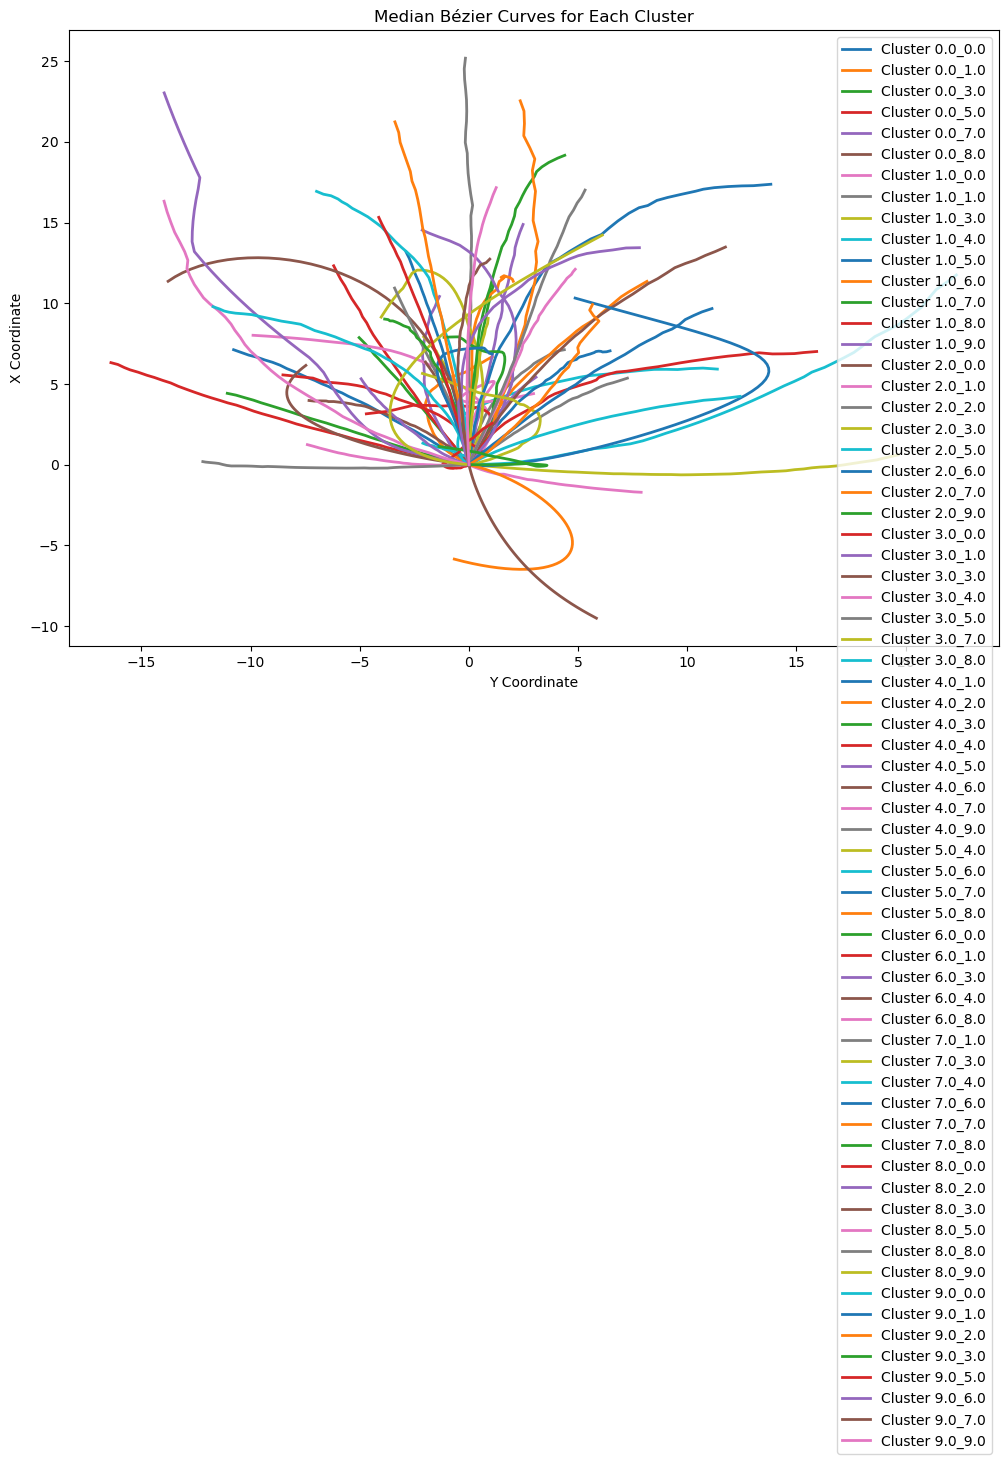

In [23]:
# Function to calculate the median route for each cluster
def calculate_cluster_medians(df):
    cluster_medians = {}

    # Group by cluster label
    for cluster_label, cluster_data in df.groupby('cluster_label'):
        # Extract bezier curves as numpy array
        bezier_curves = np.array(cluster_data['bezier_curve'].tolist())  # Shape: (num_routes, 400)

        # Split into x and y coordinates
        x_coords = bezier_curves[:, ::2]  # Extract even-indexed columns (0, 2, 4, ...)
        y_coords = bezier_curves[:, 1::2]

        # Calculate median for x and y
        median_x = np.median(x_coords, axis=0)
        median_y = np.median(y_coords, axis=0)

        # Store the median route for the cluster
        cluster_medians[cluster_label] = (median_x, median_y)

    return cluster_medians

def plot_cluster_medians(cluster_medians):
    count = 0
    plt.figure(figsize=(12, 8))

    for cluster_label, (median_x, median_y) in cluster_medians.items():
        plt.plot(median_y, median_x, label=f"Cluster {cluster_label}", linewidth=2)  # Plot y vs x
        count += 1

    plt.title("Median Bézier Curves for Each Cluster")
    plt.xlabel("Y Coordinate")
    plt.ylabel("X Coordinate")
    plt.legend()
    plt.show()

# Calculate cluster medians
cluster_medians = calculate_cluster_medians(routes_df)

# Plot the median routes
plot_cluster_medians(cluster_medians)

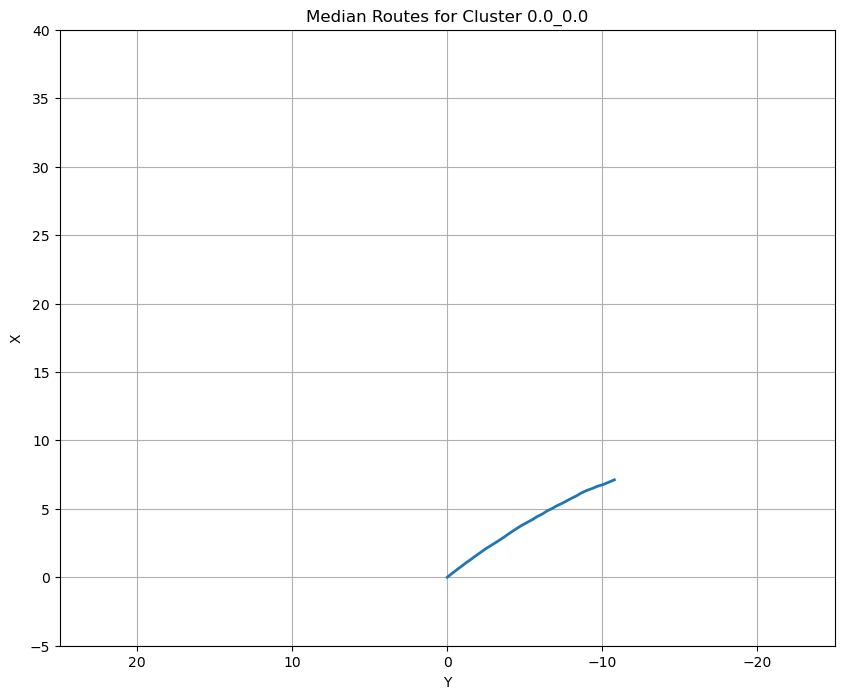

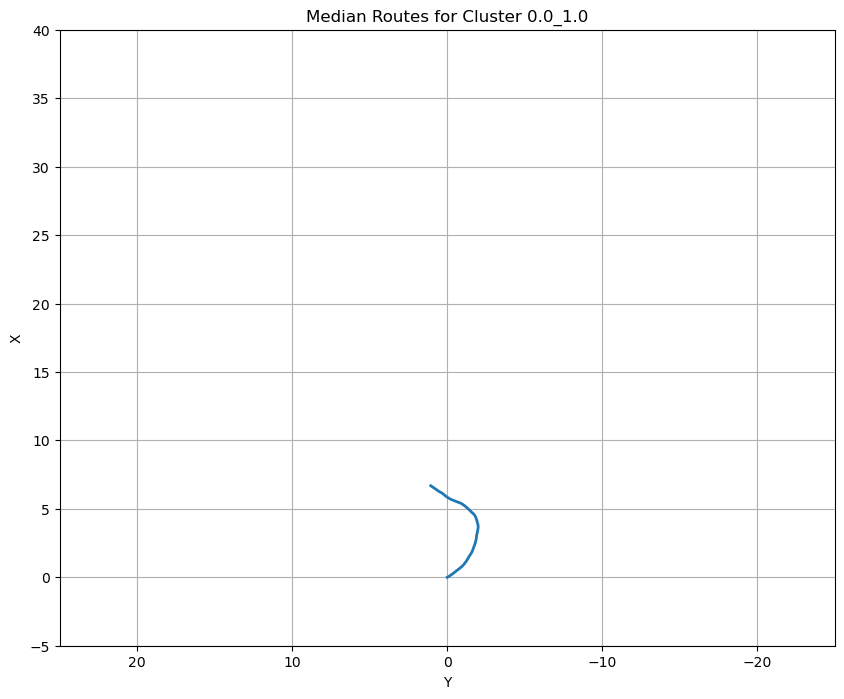

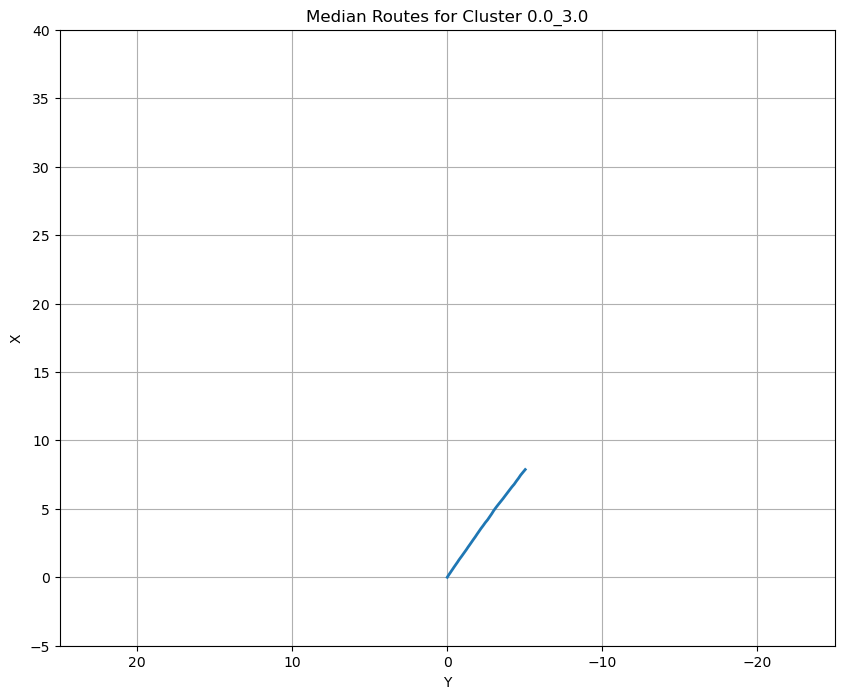

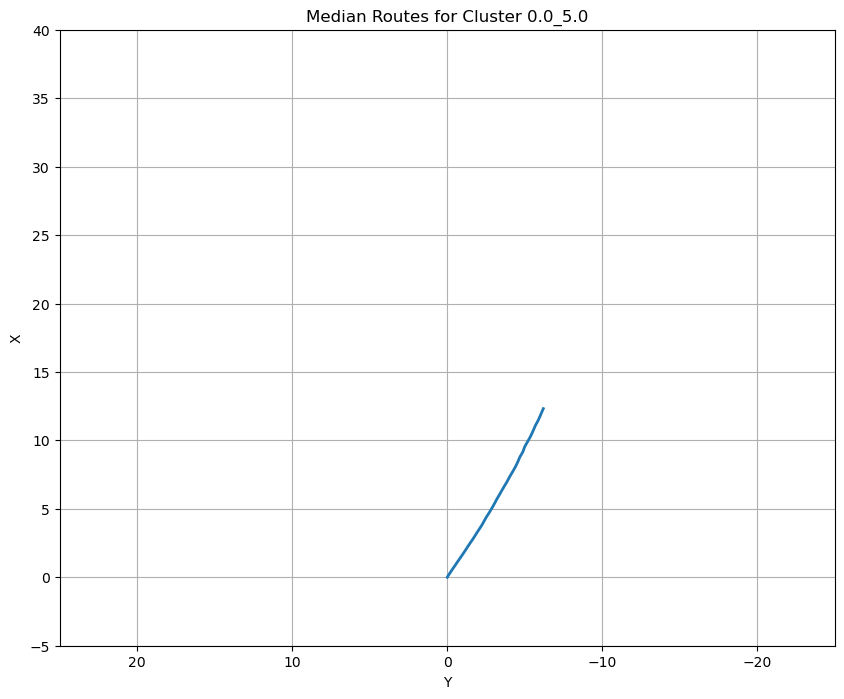

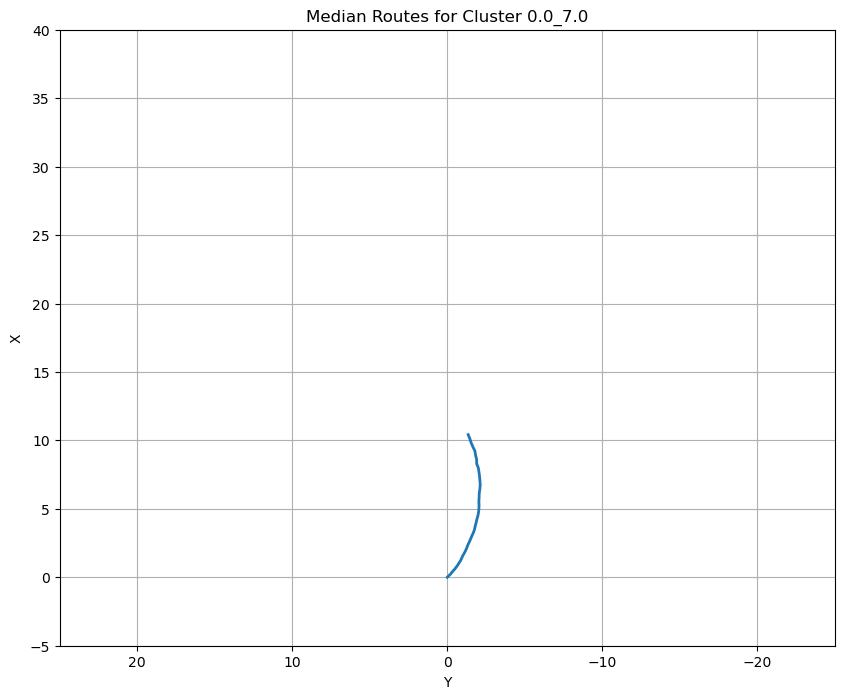

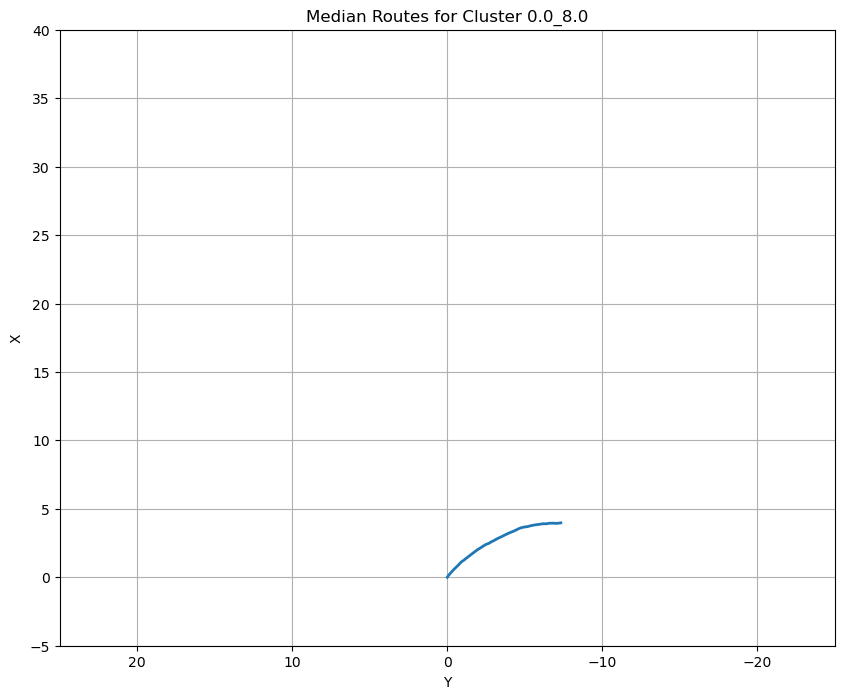

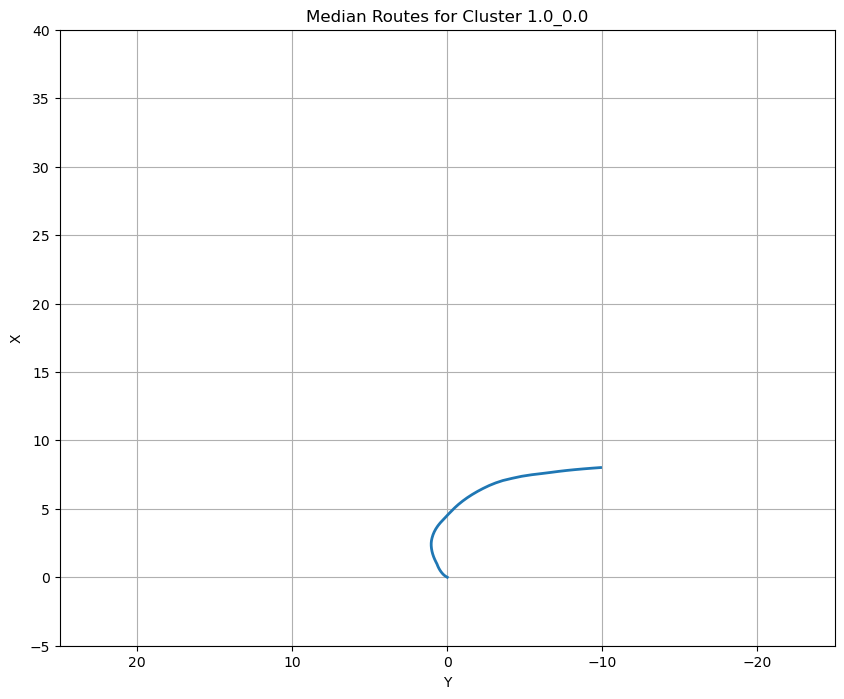

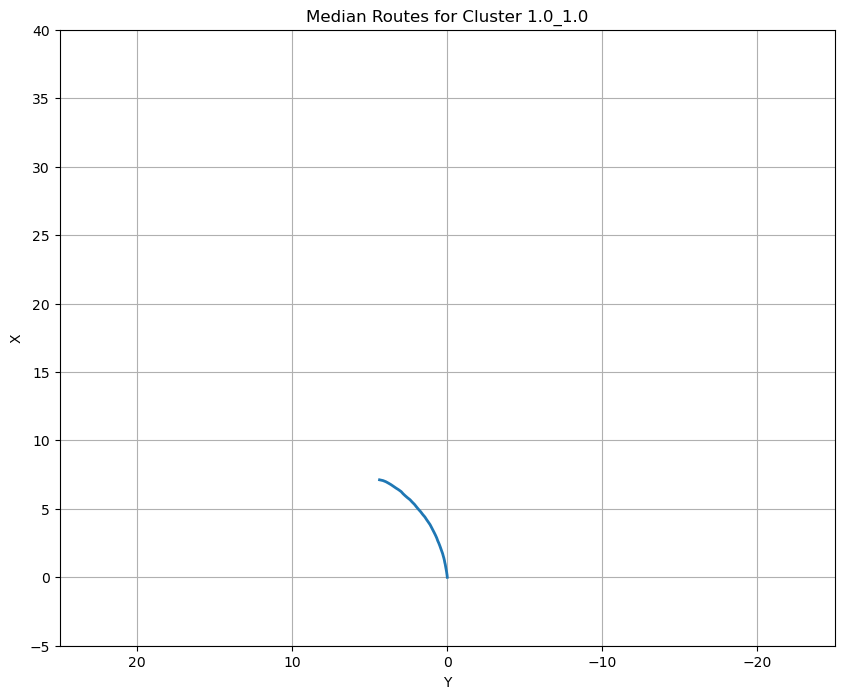

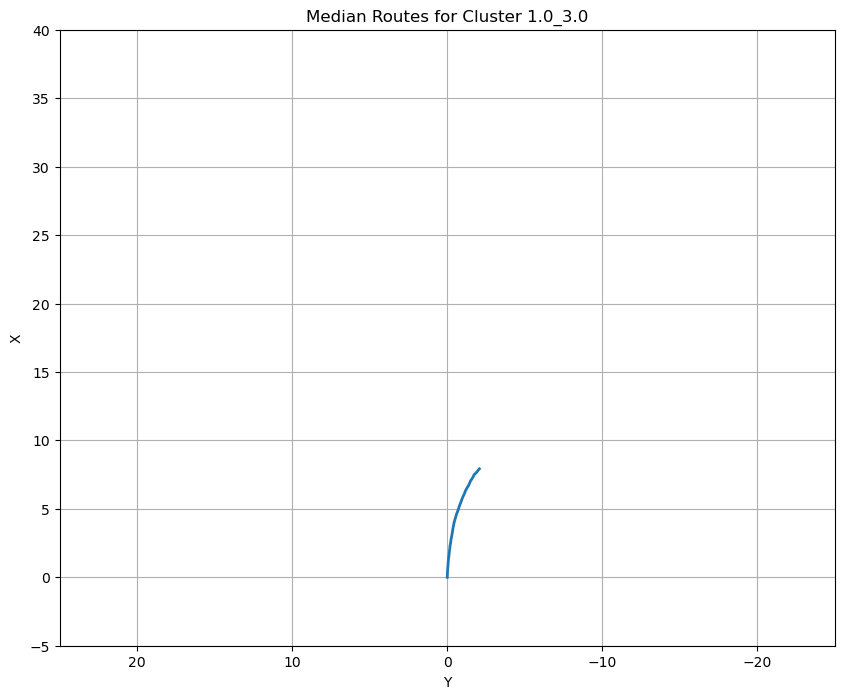

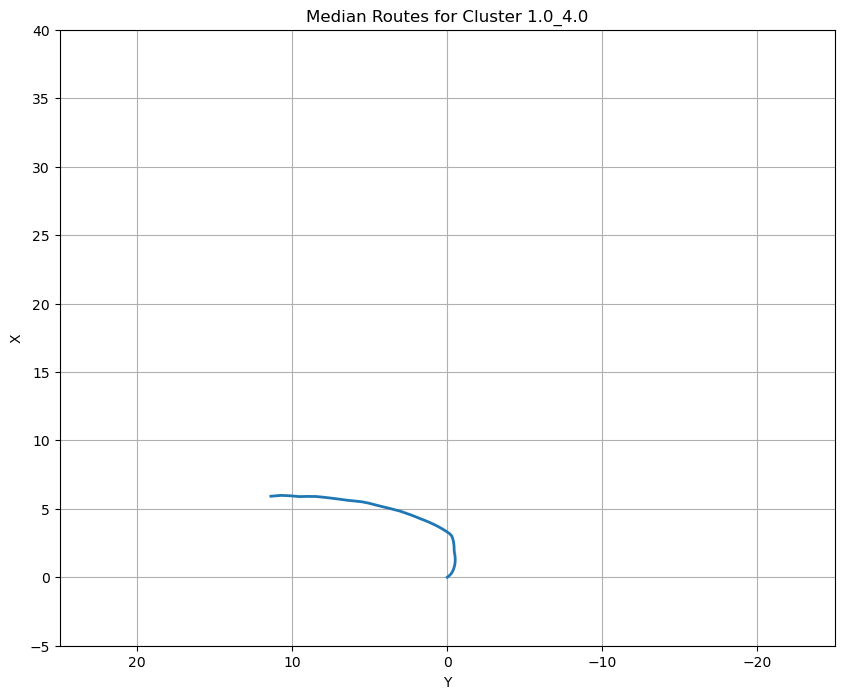

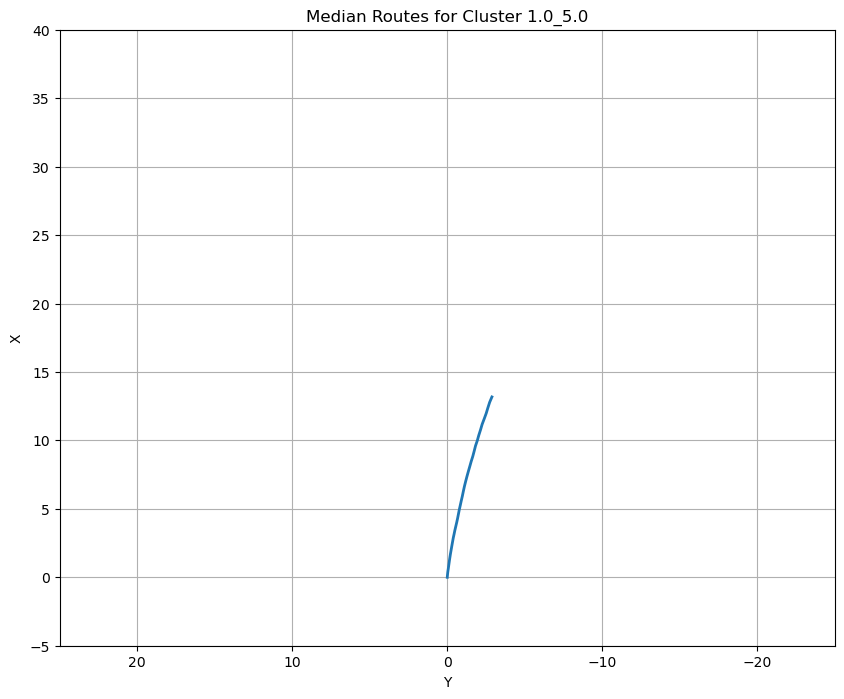

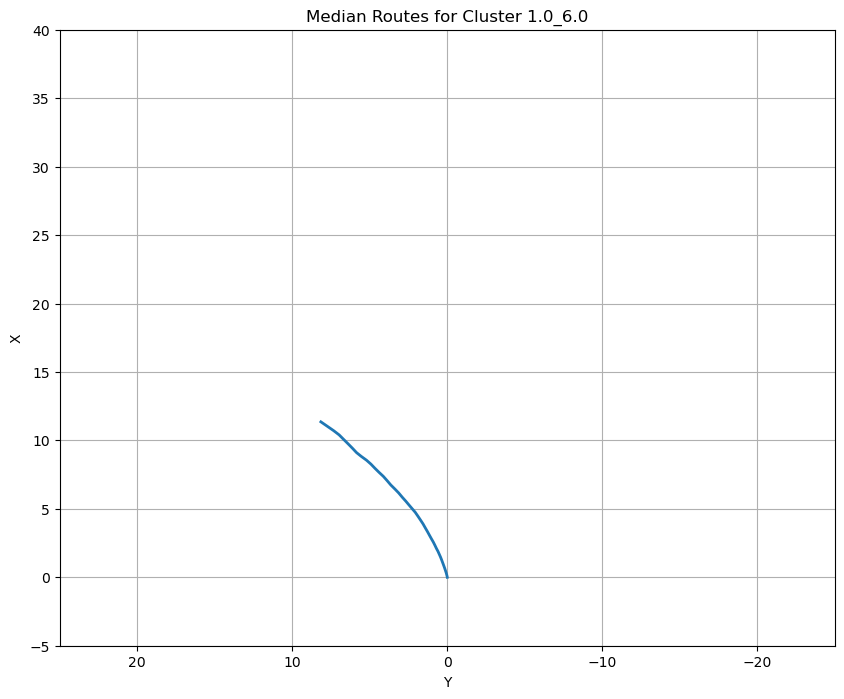

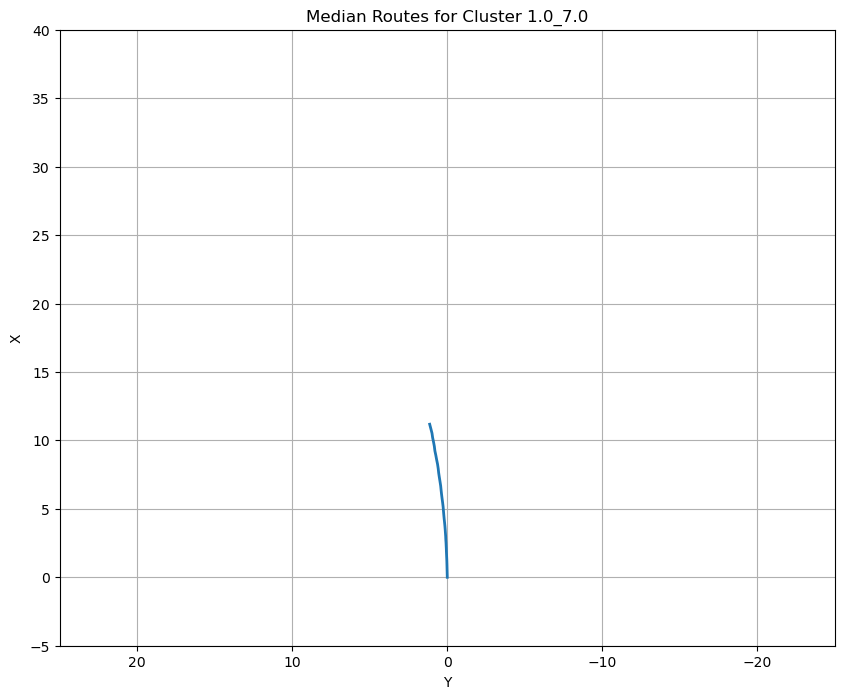

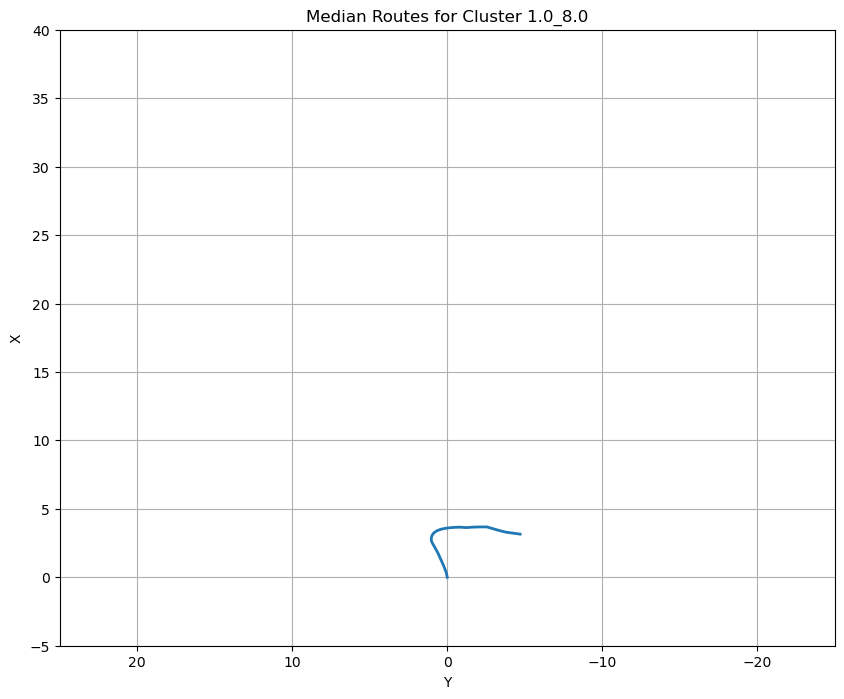

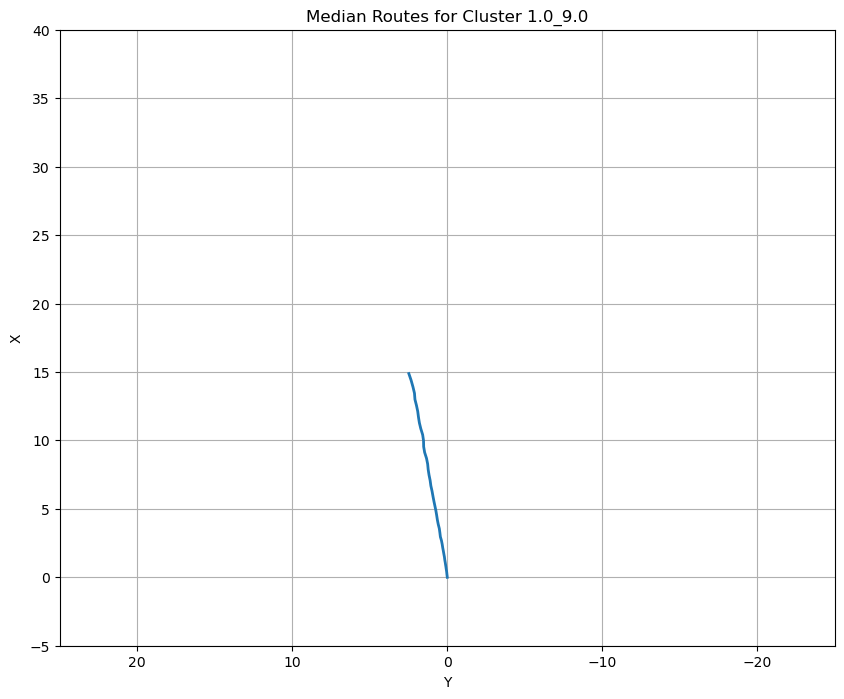

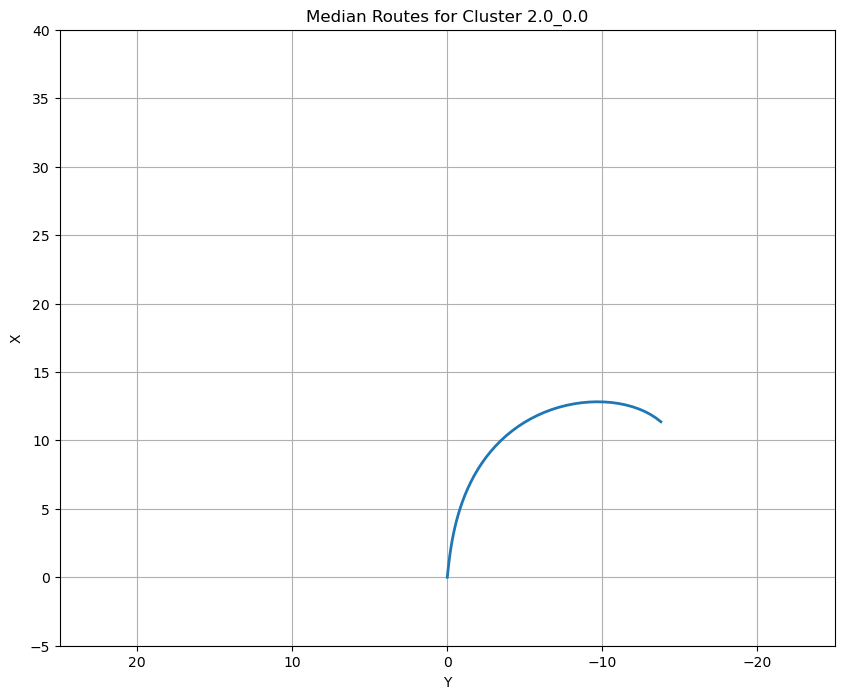

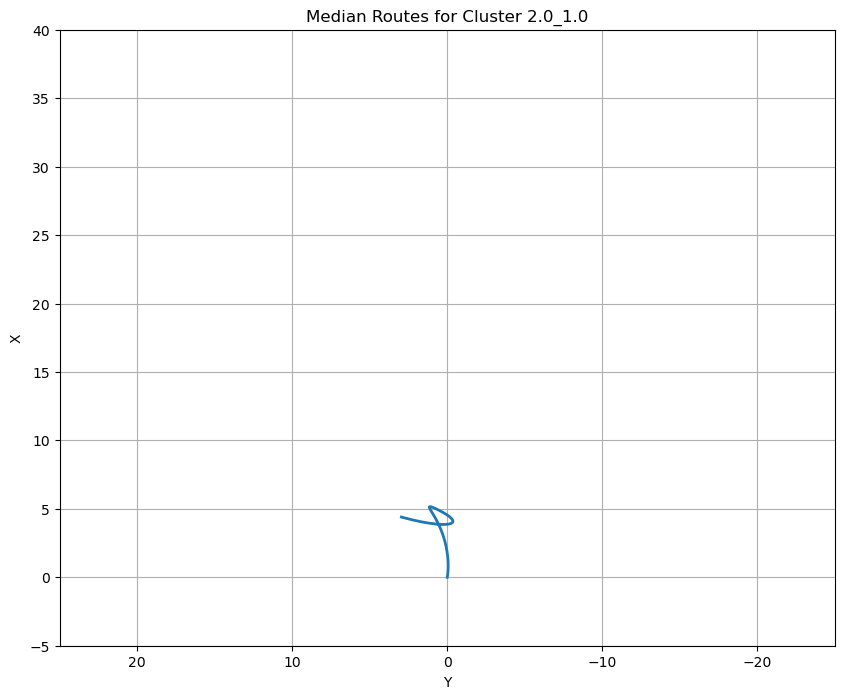

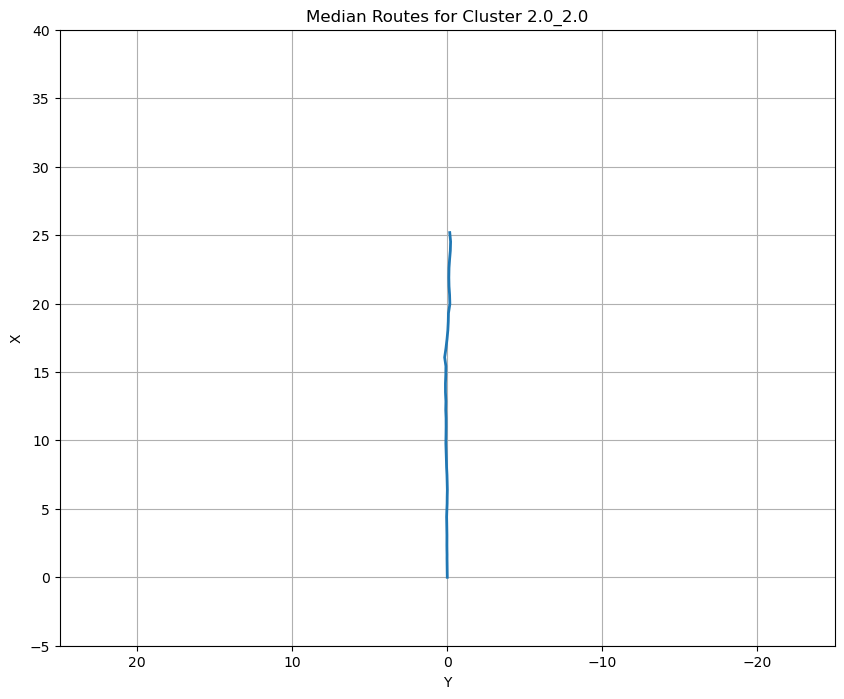

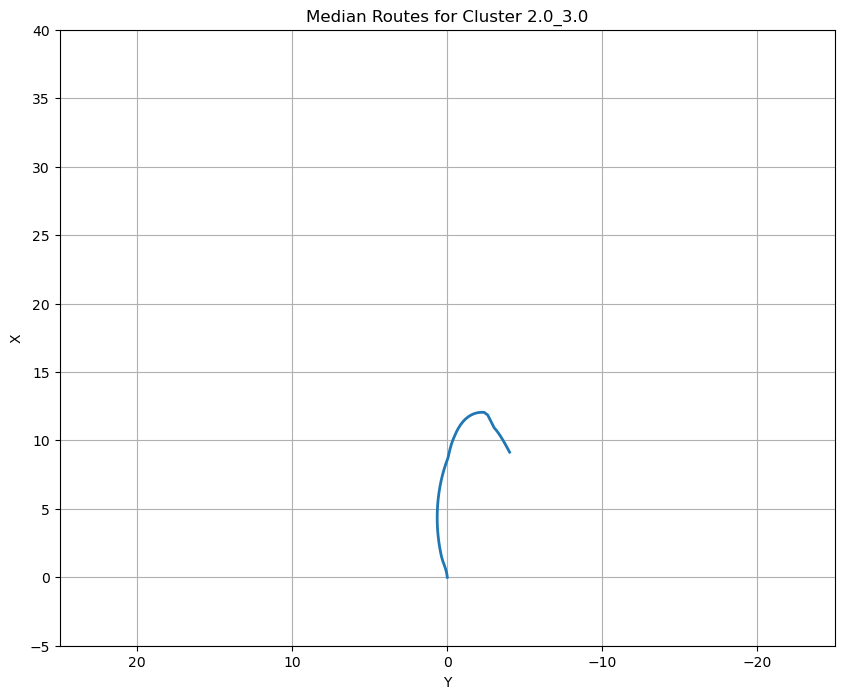

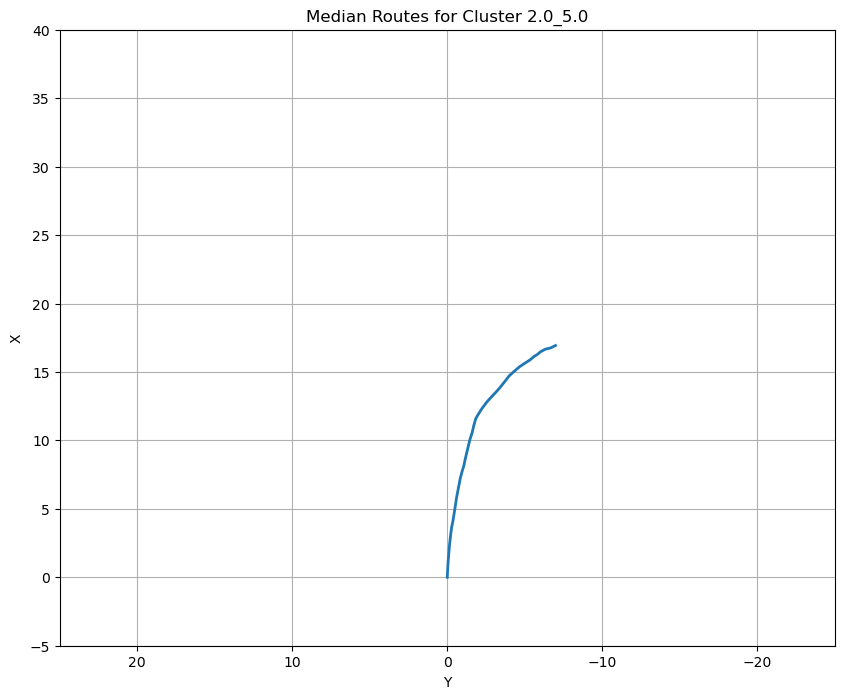

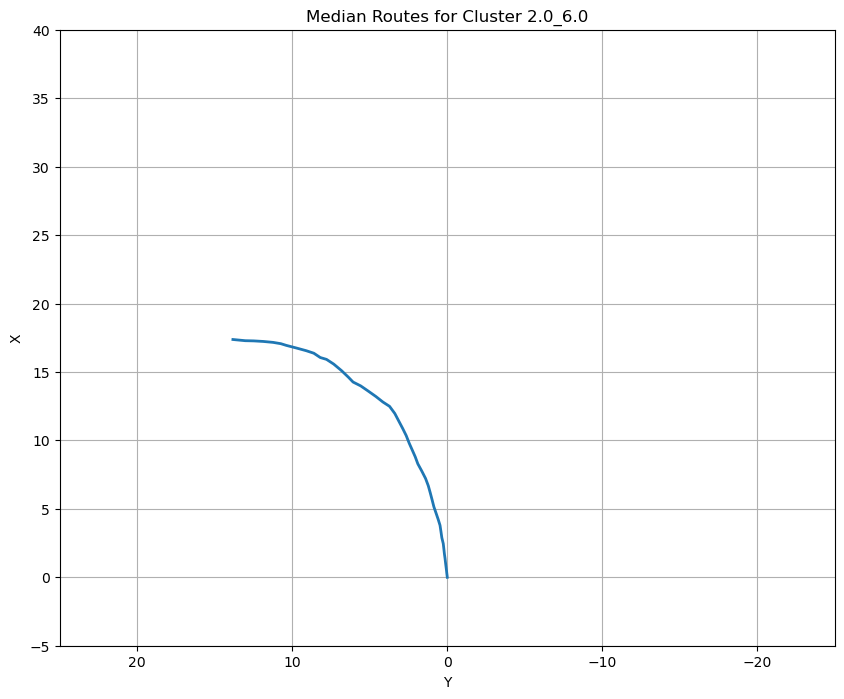

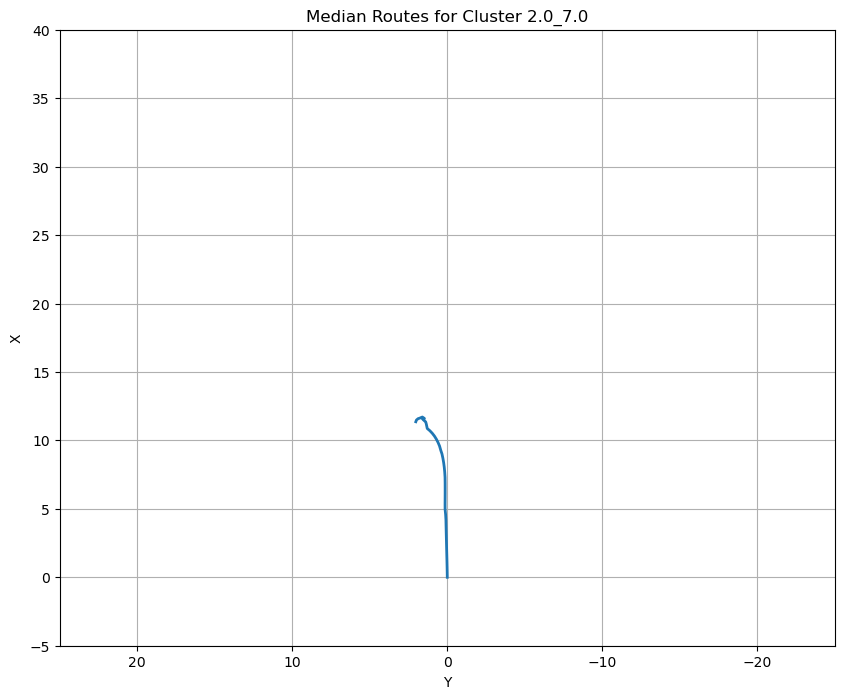

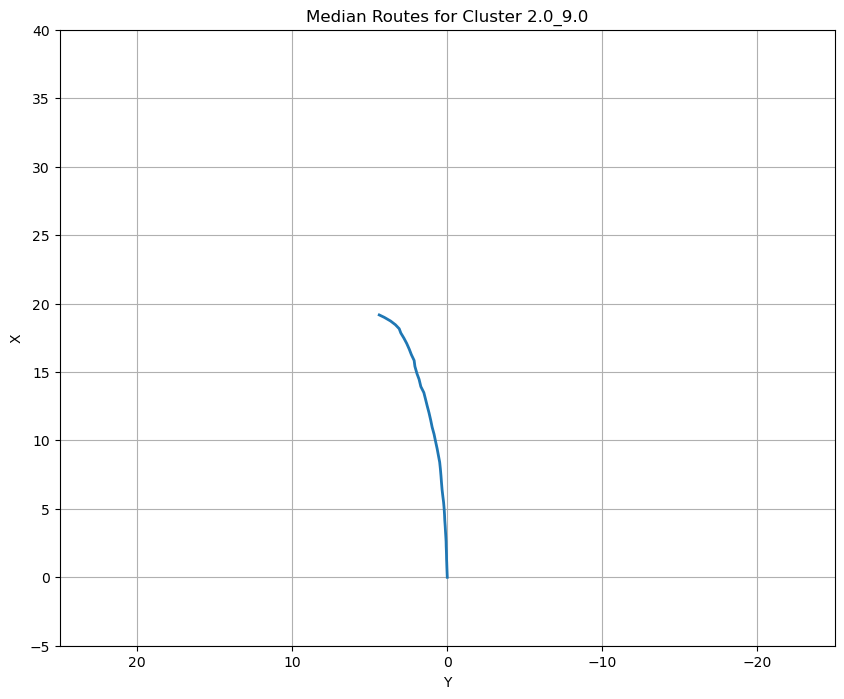

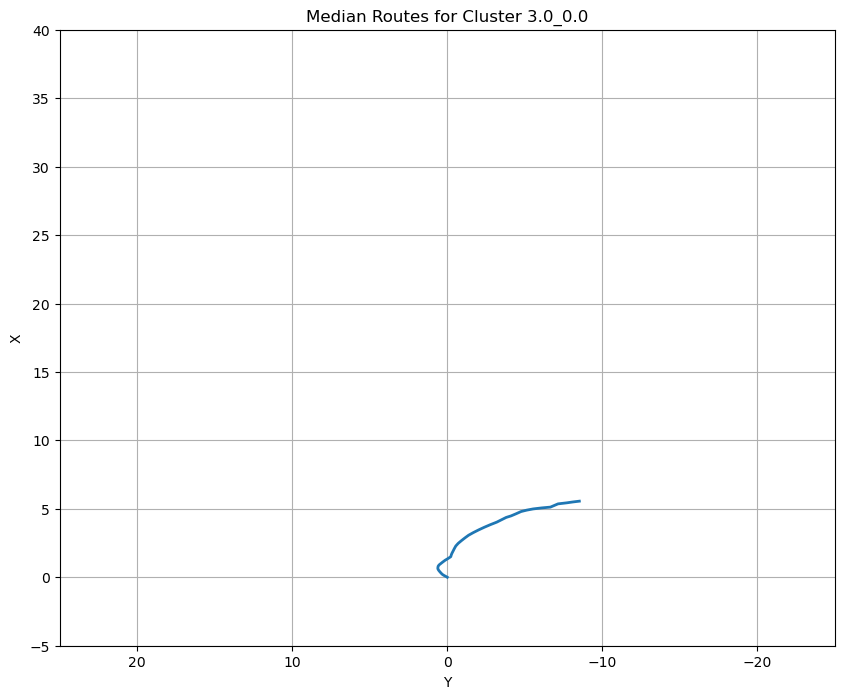

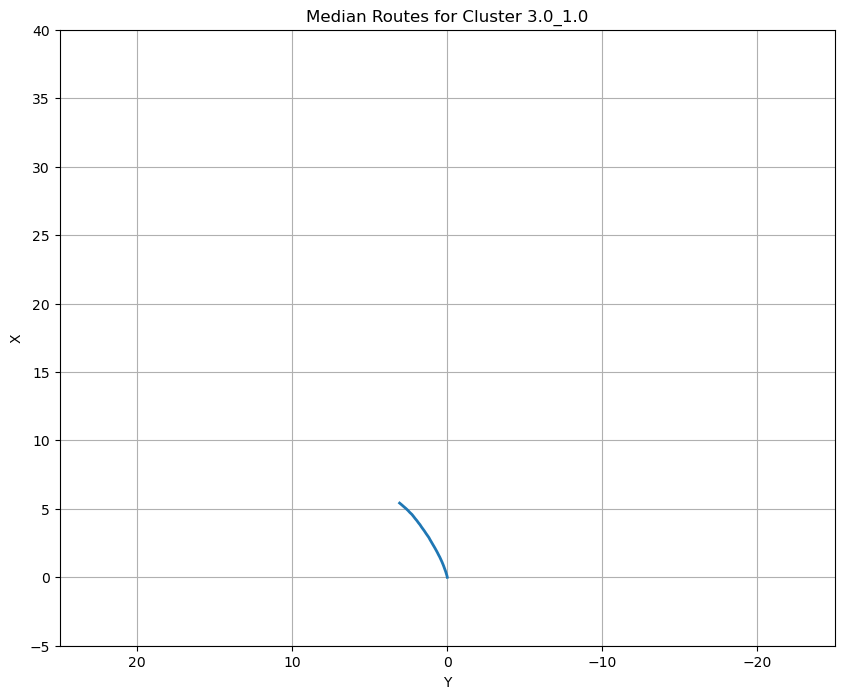

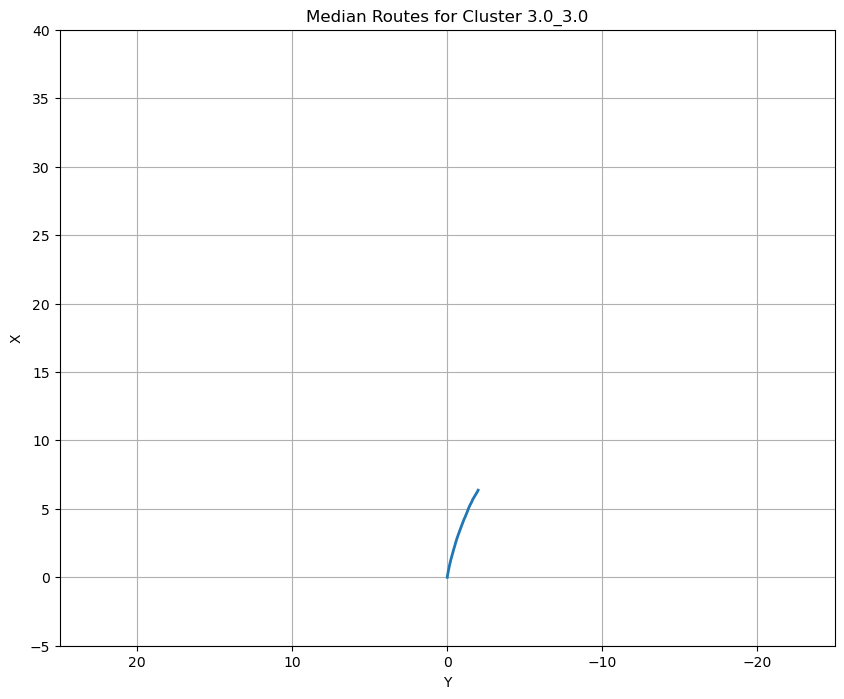

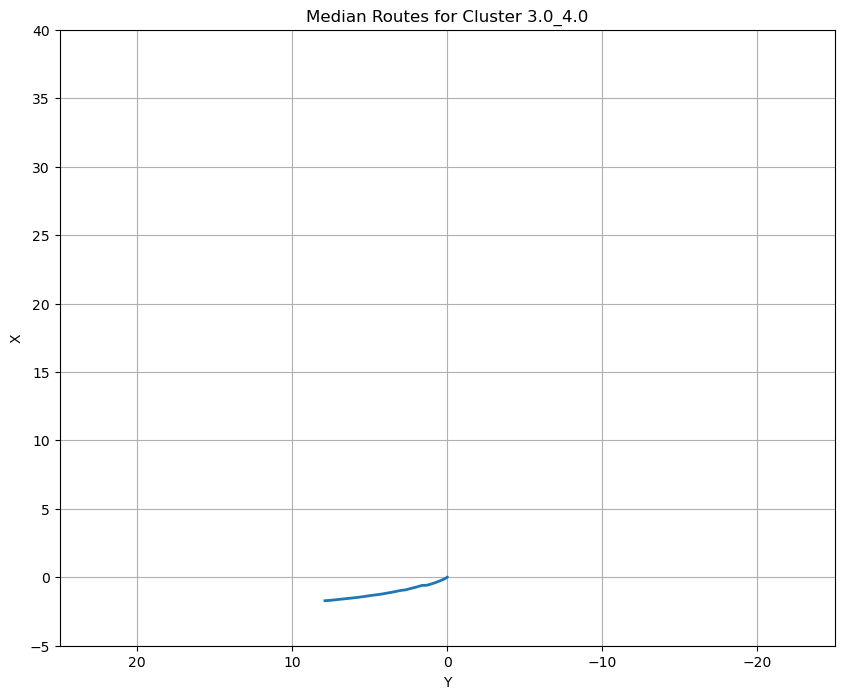

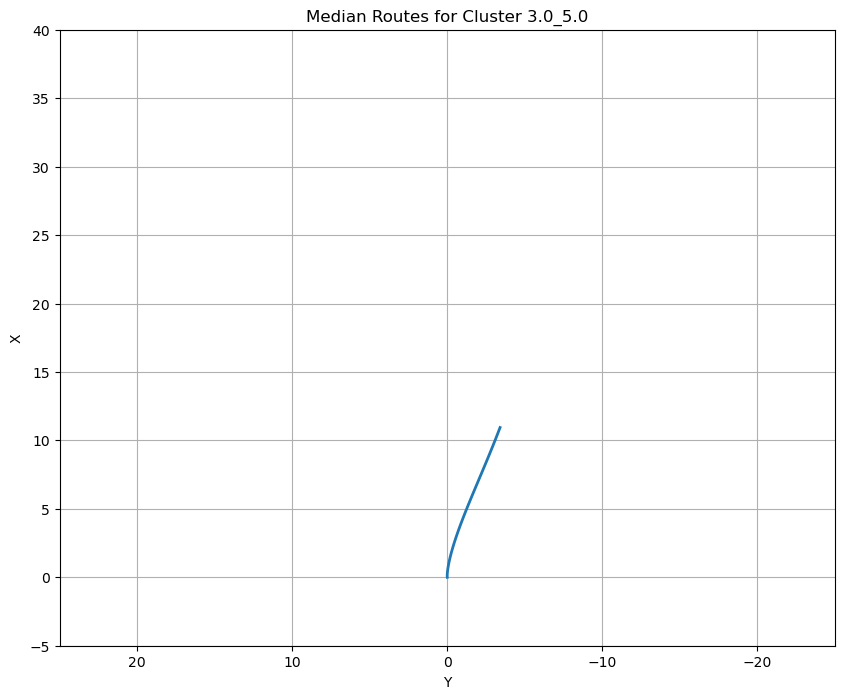

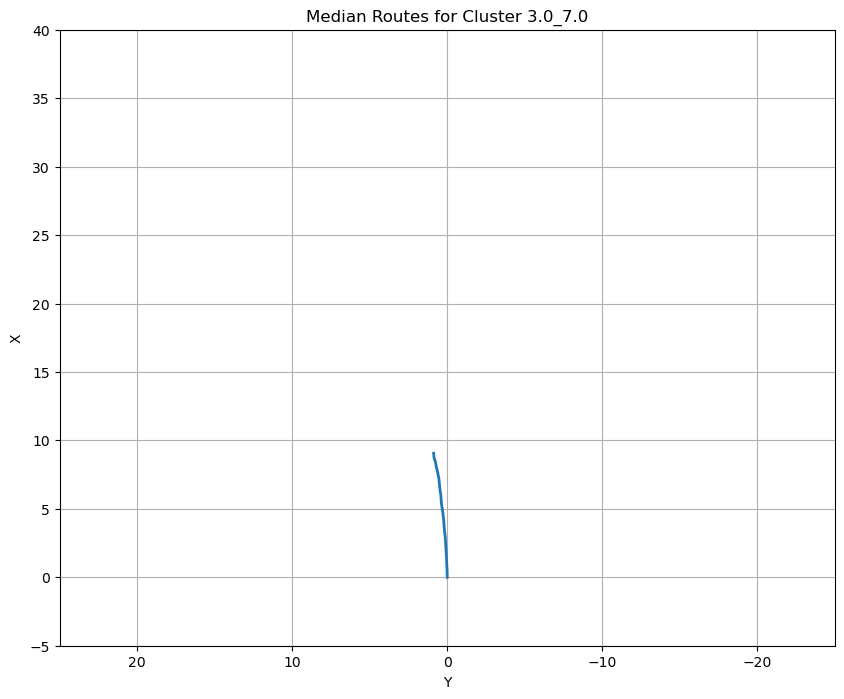

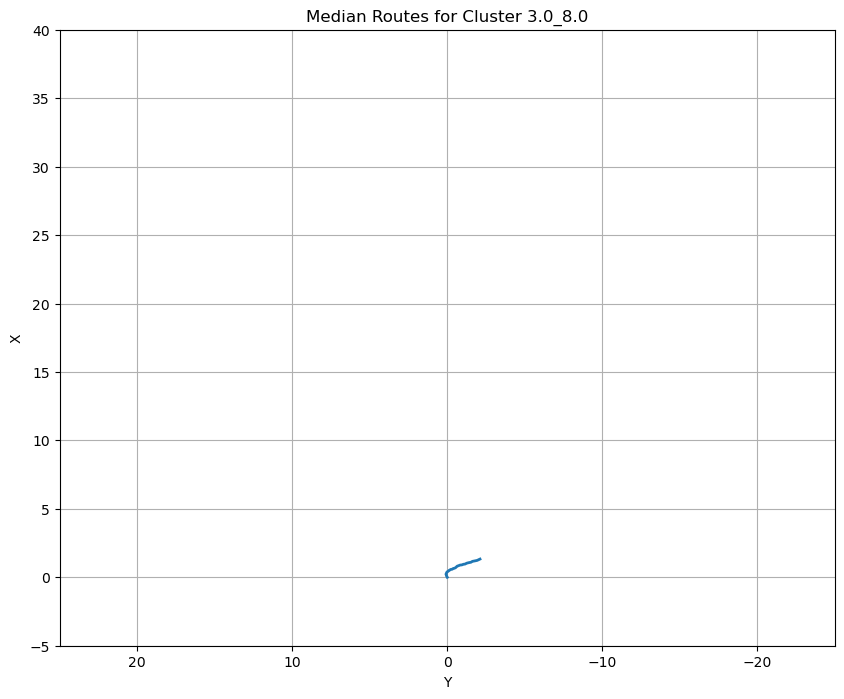

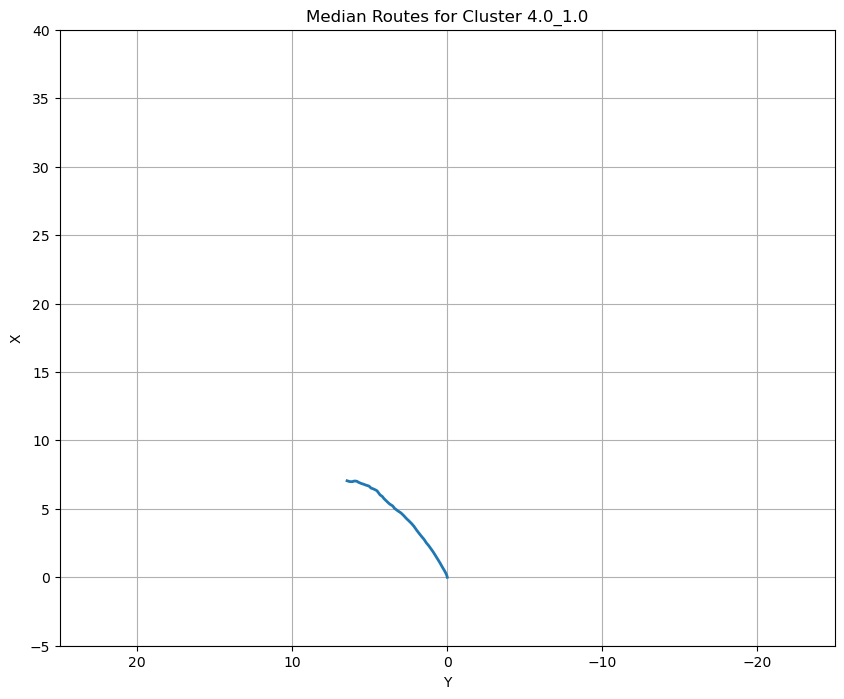

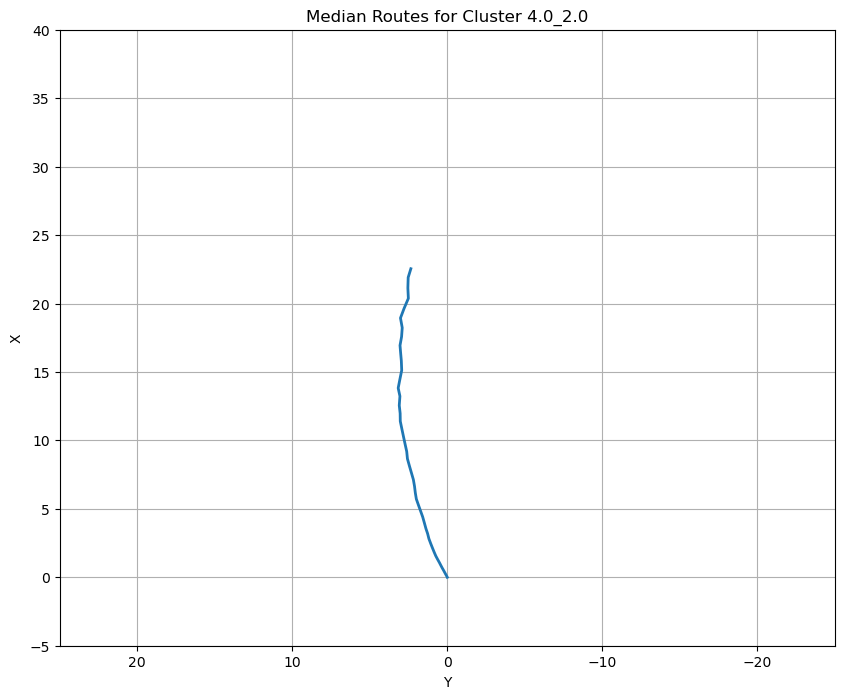

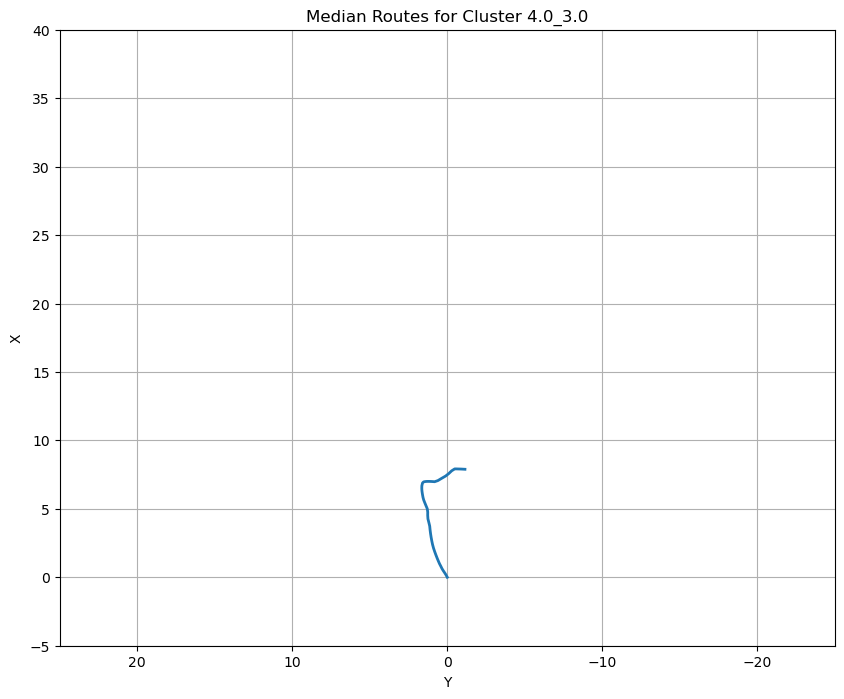

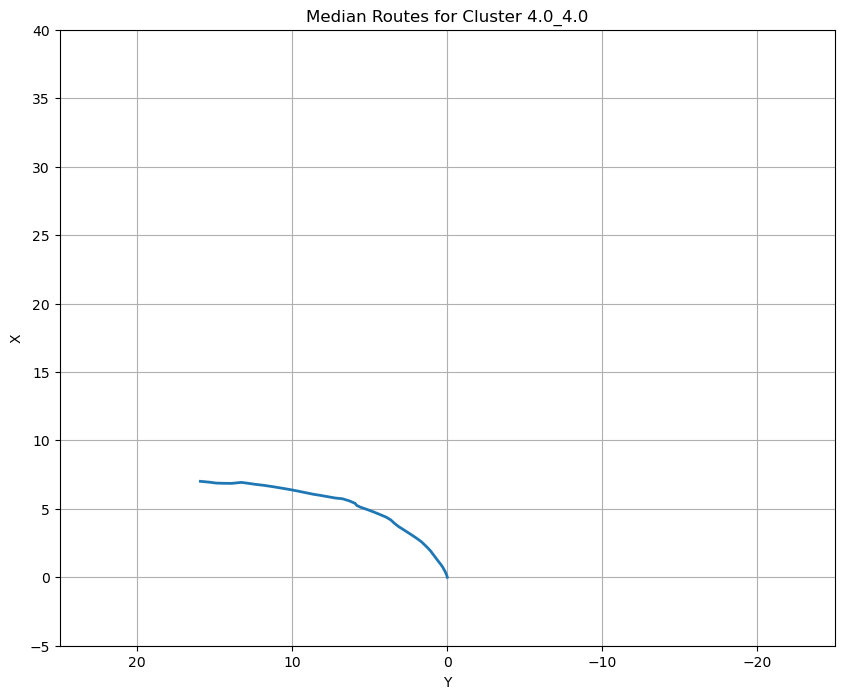

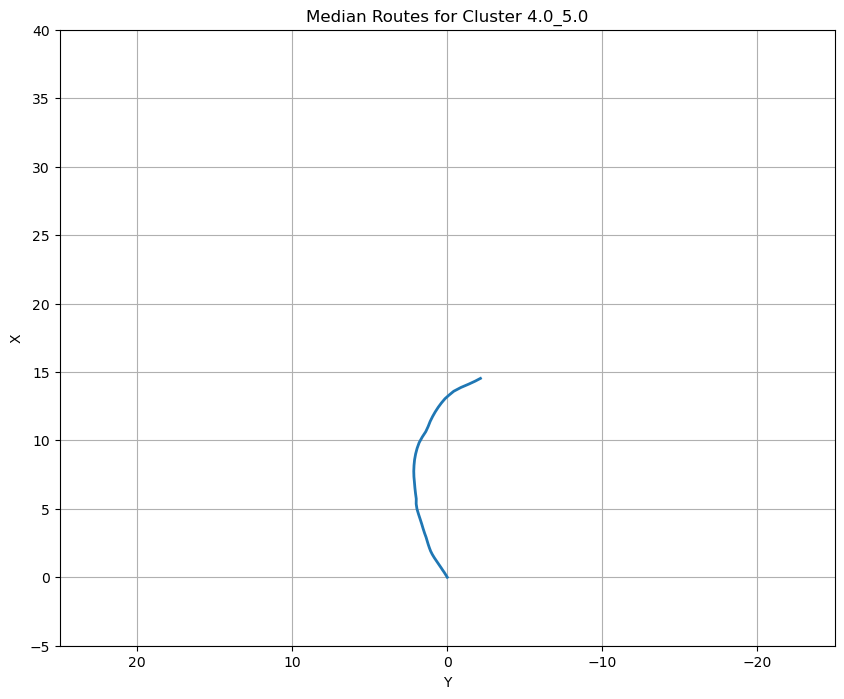

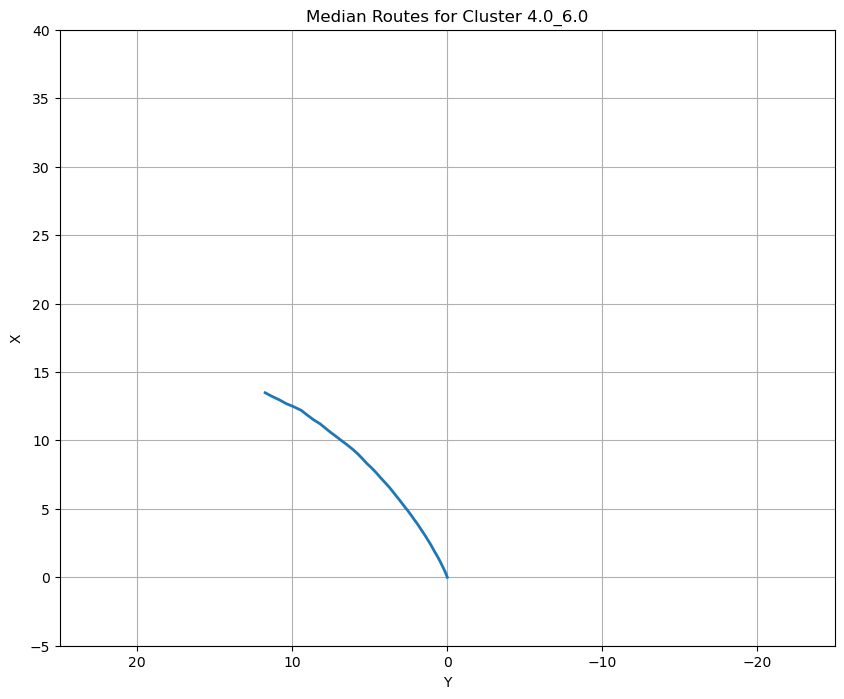

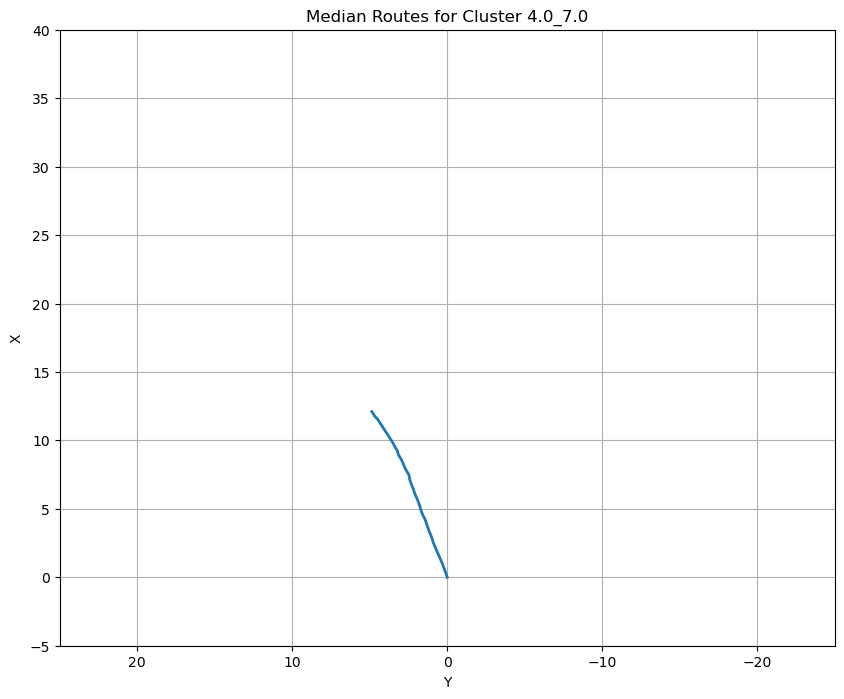

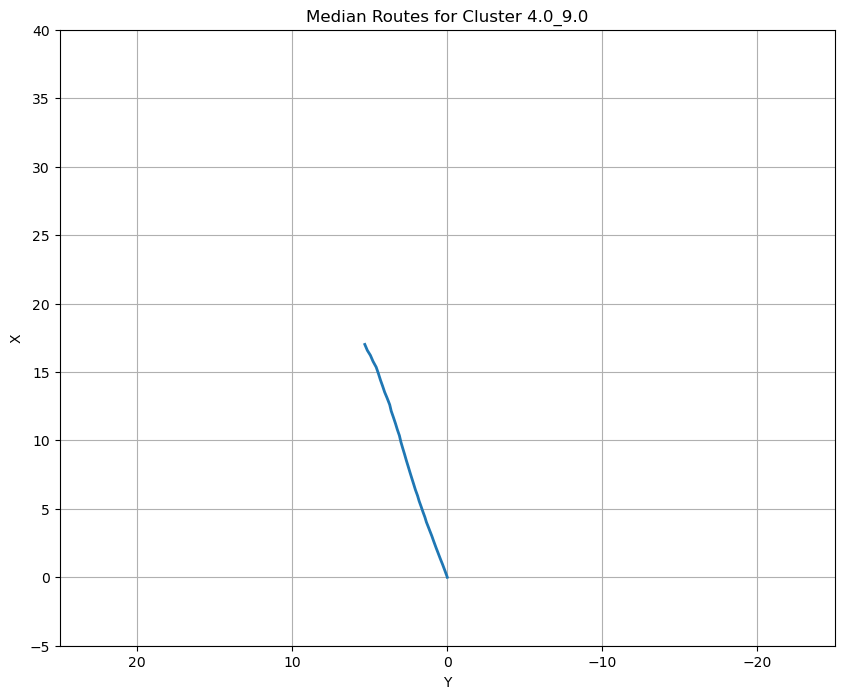

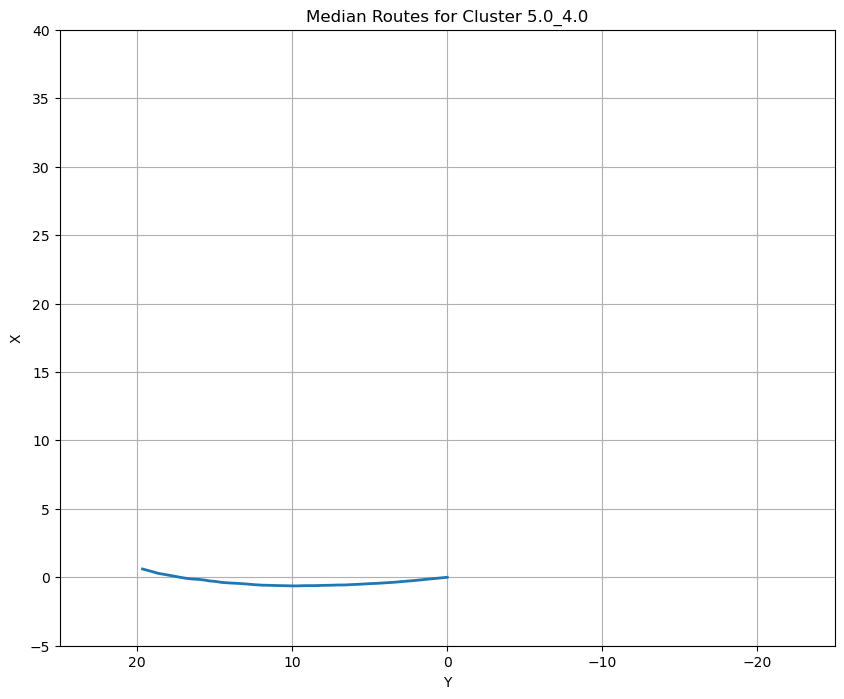

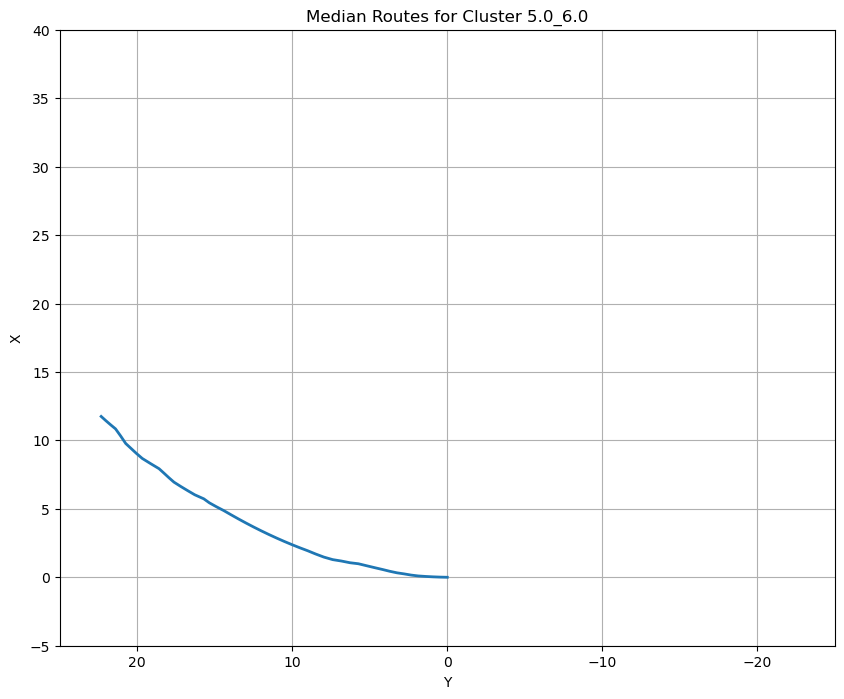

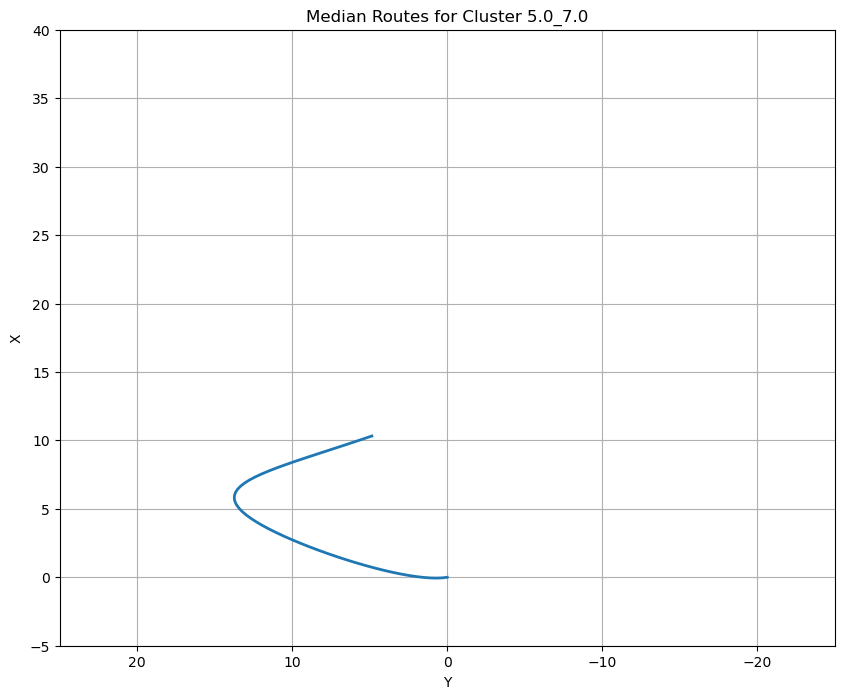

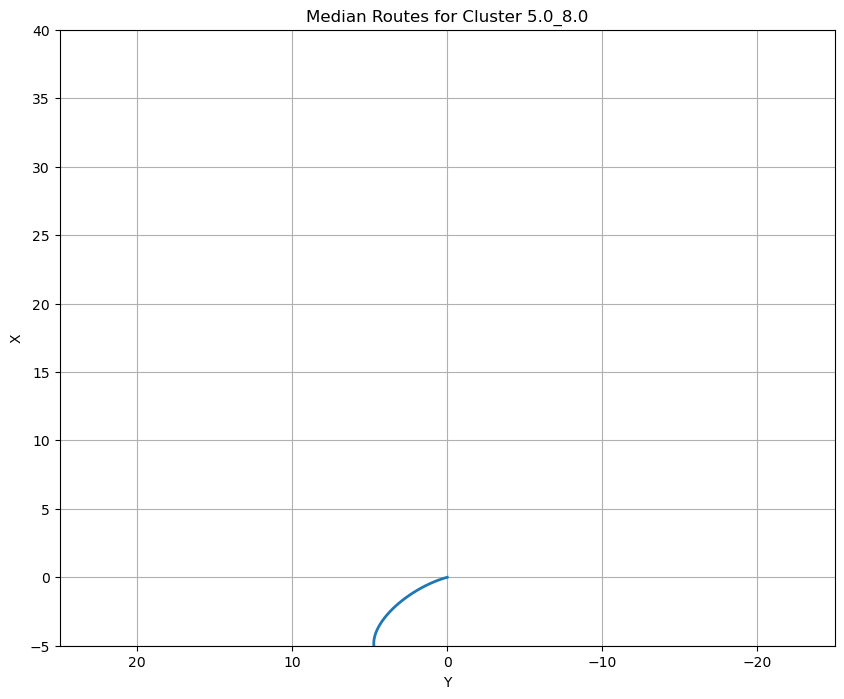

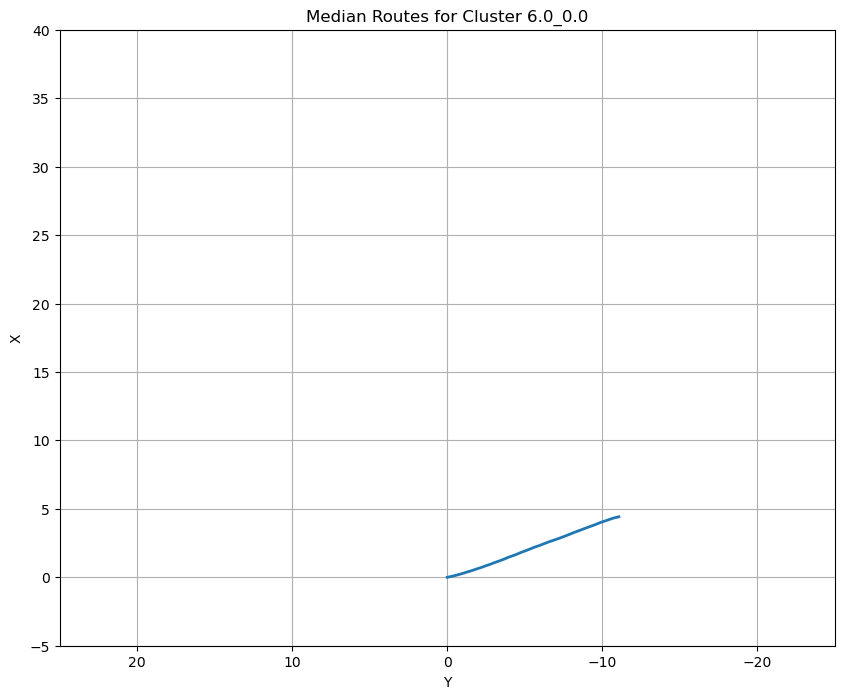

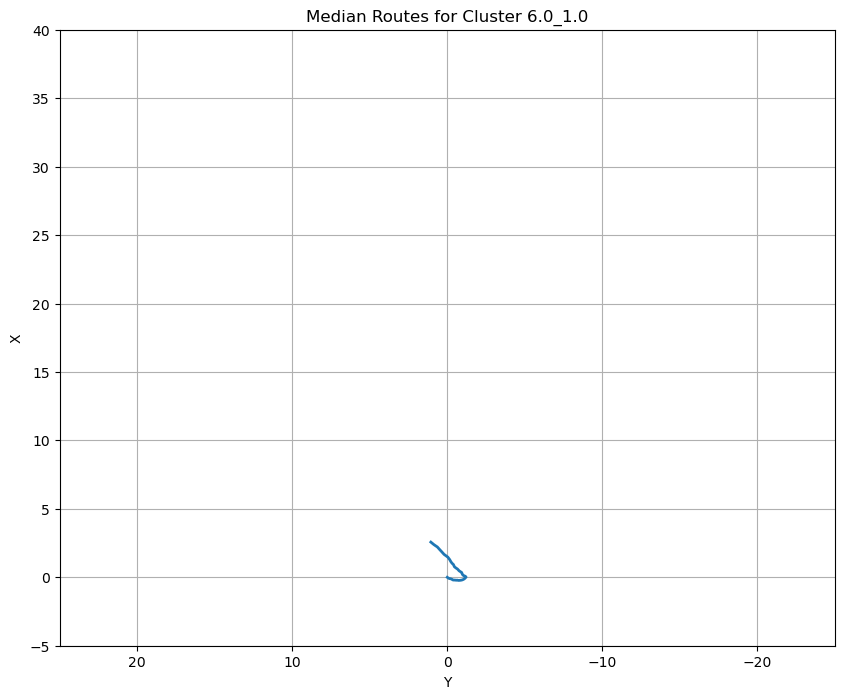

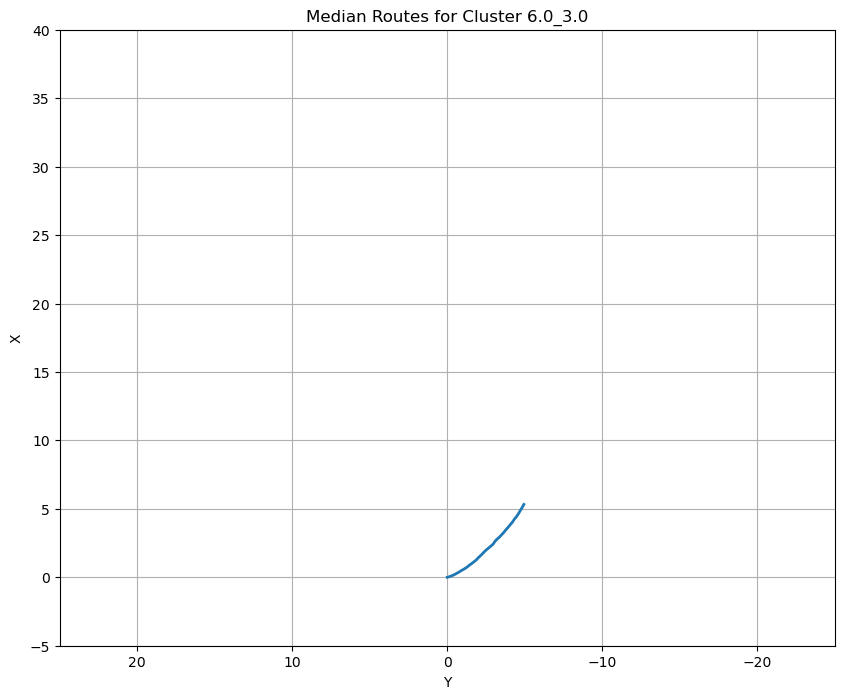

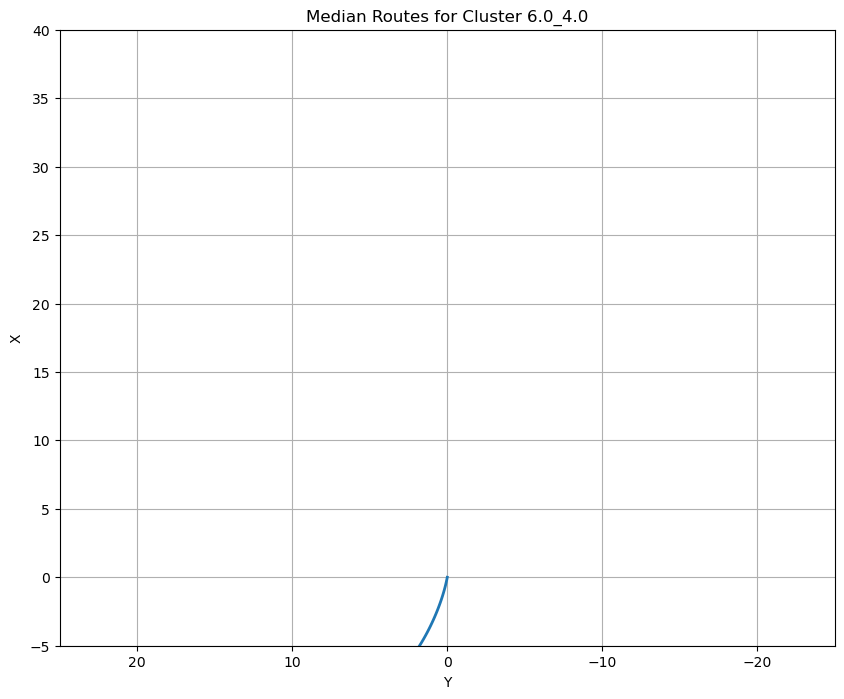

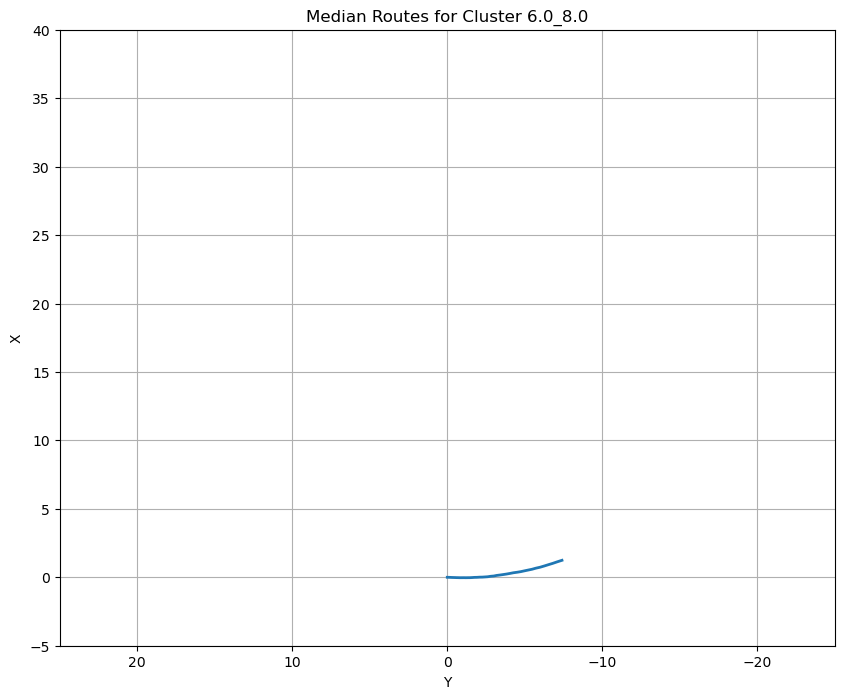

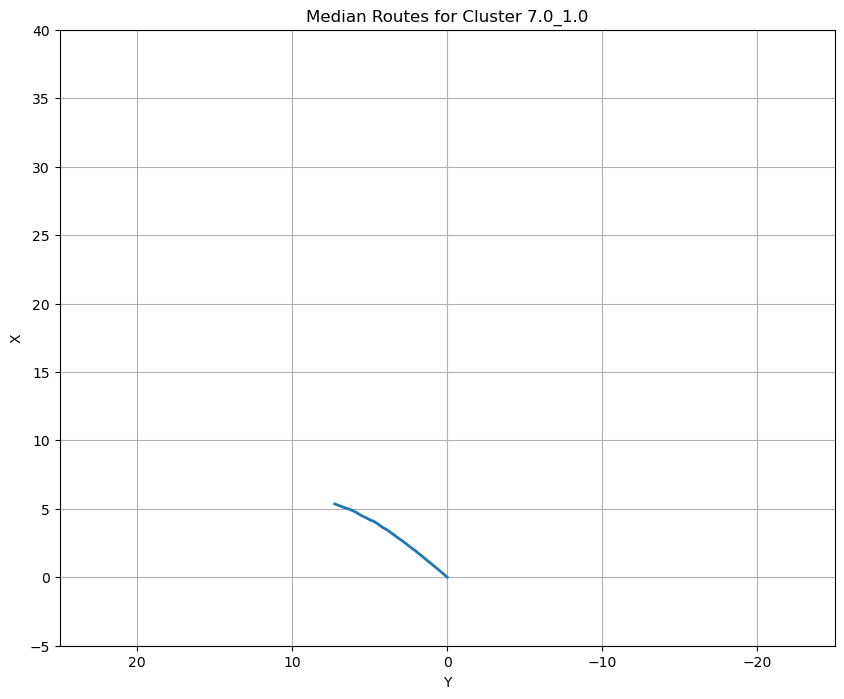

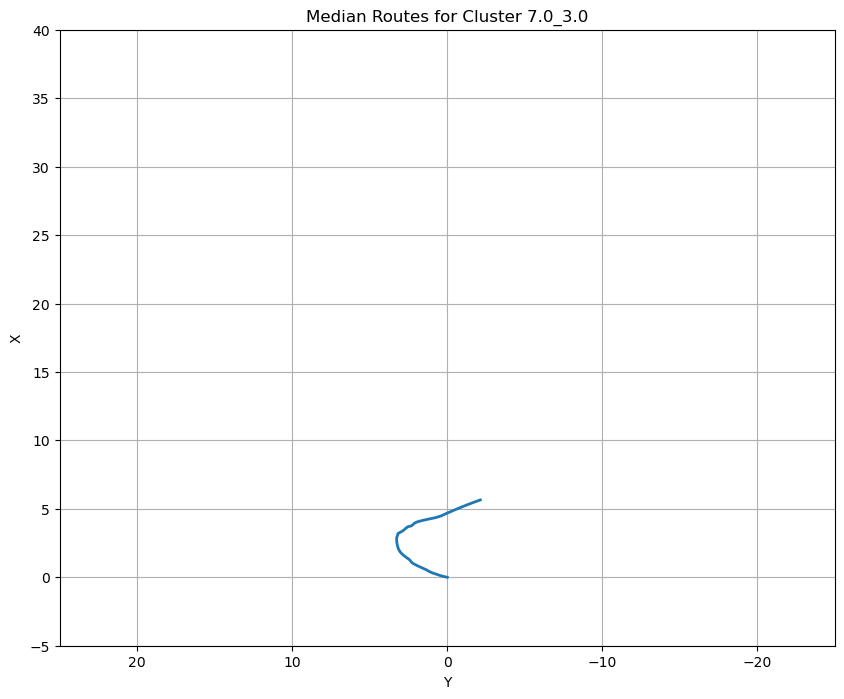

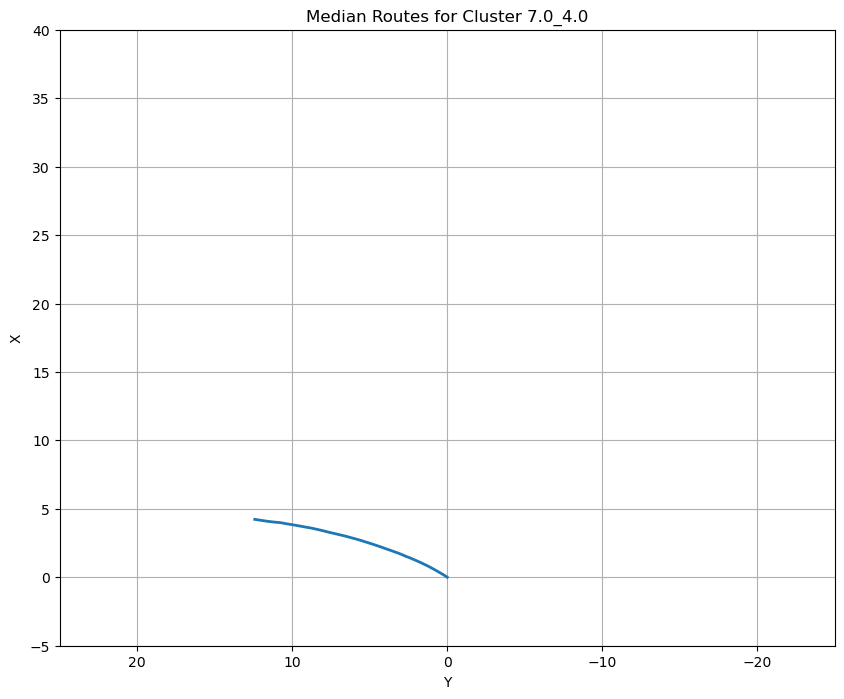

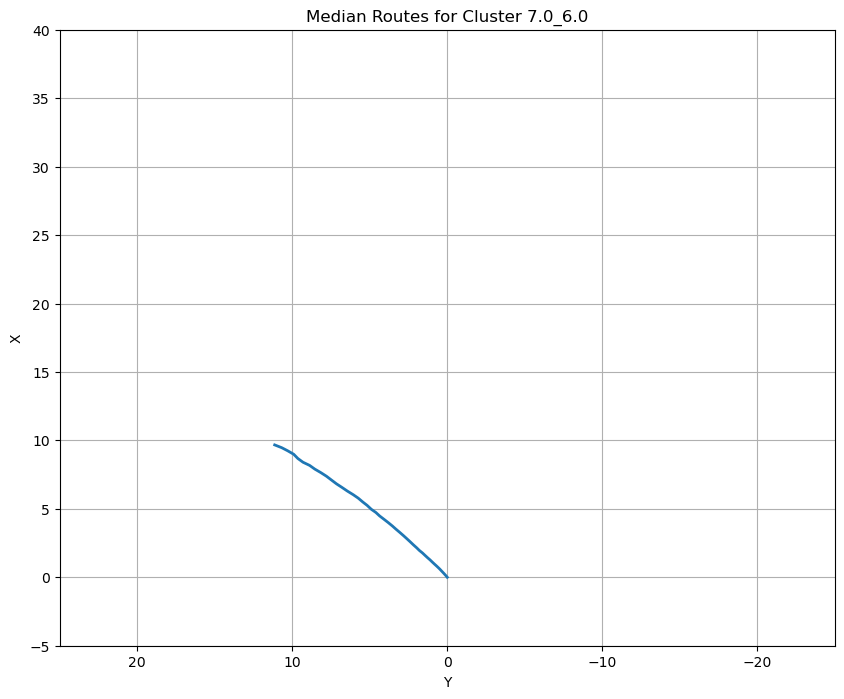

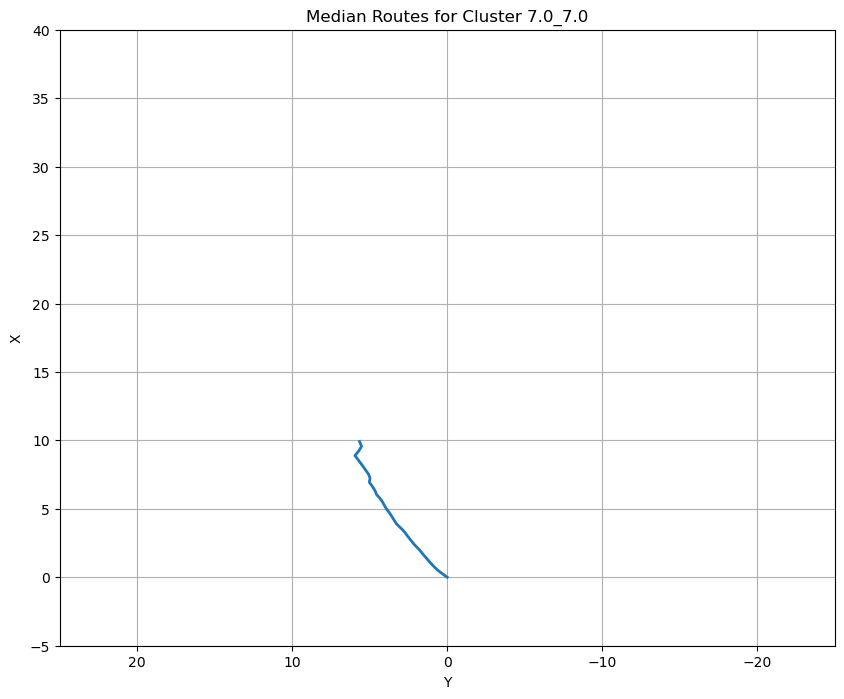

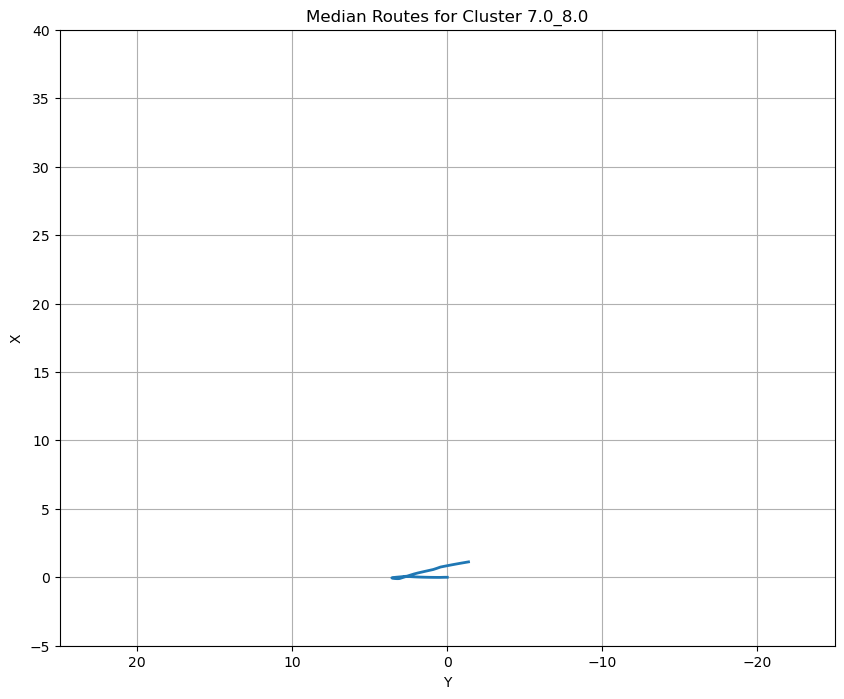

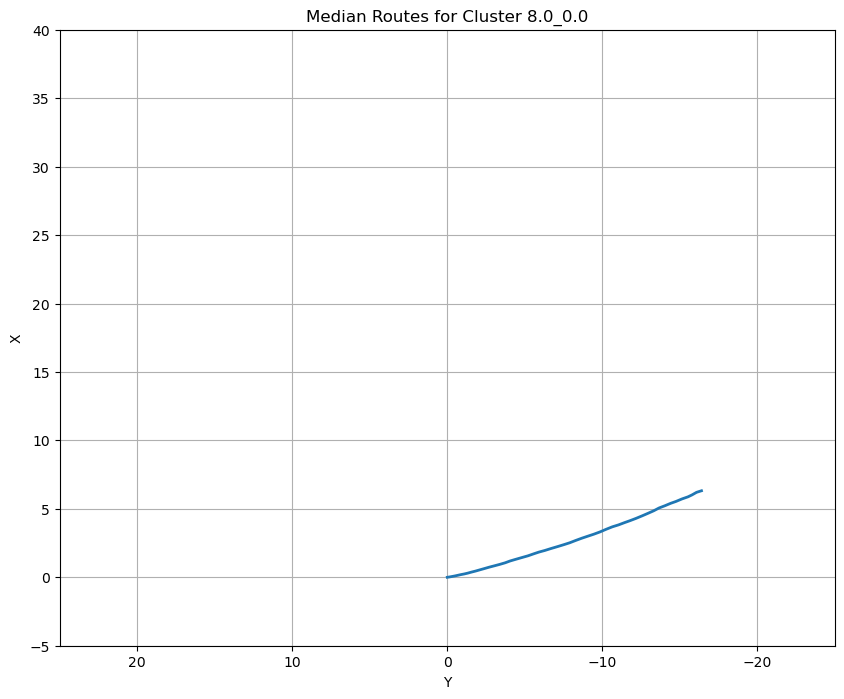

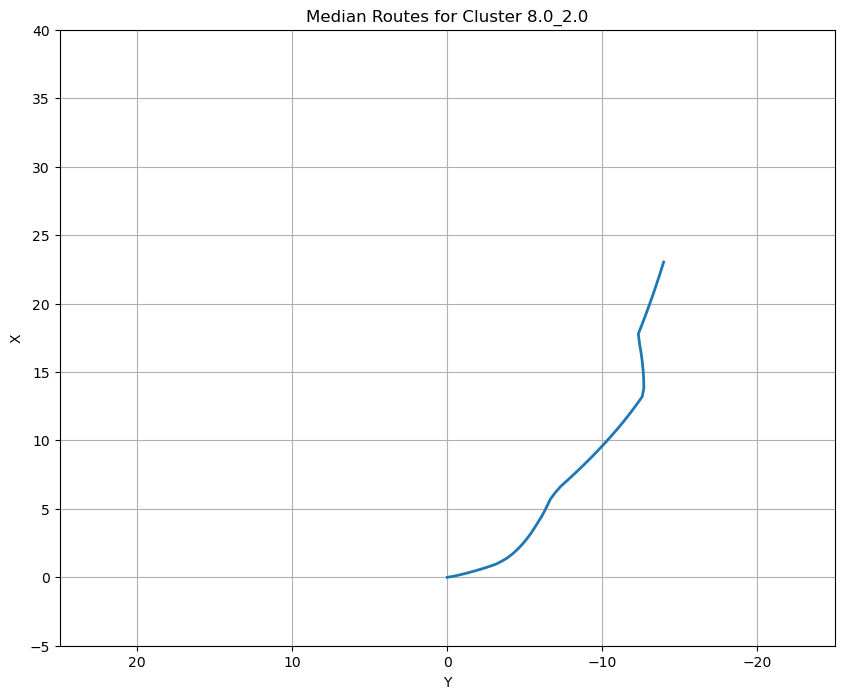

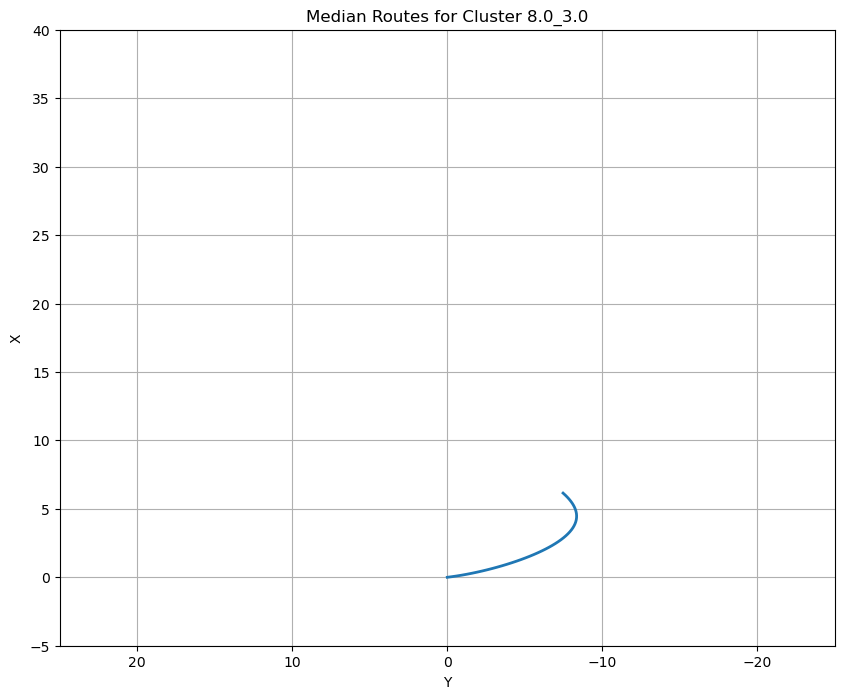

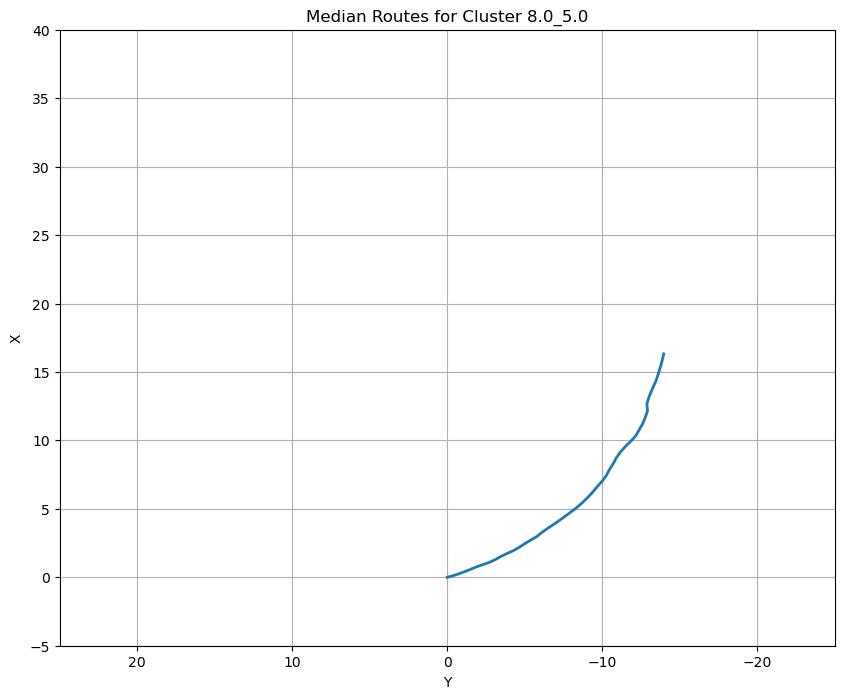

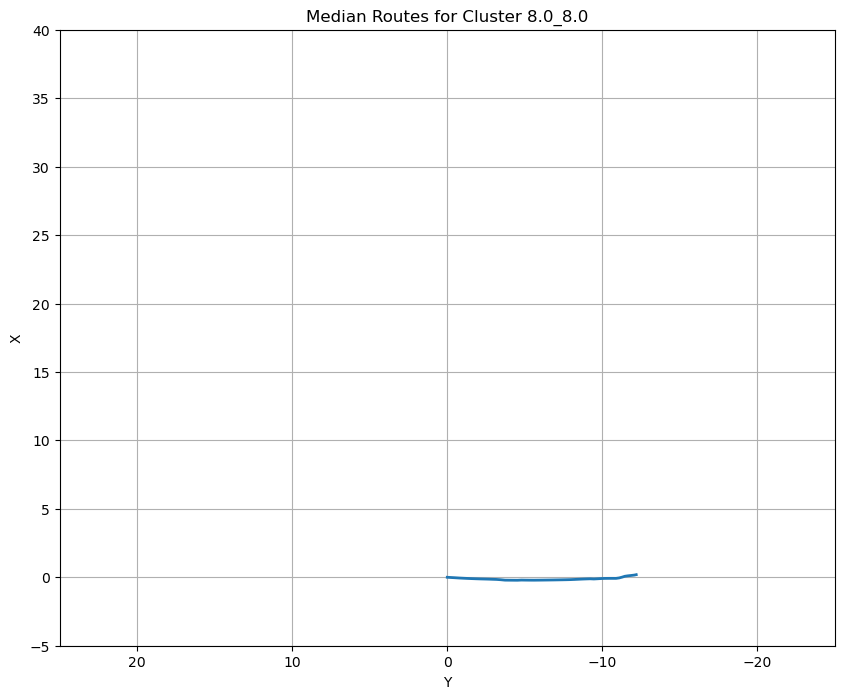

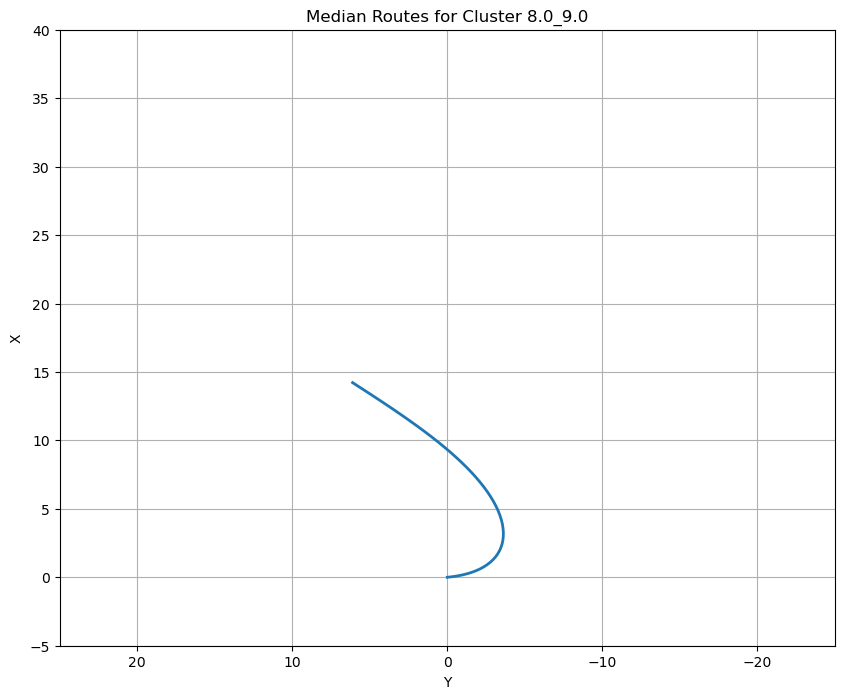

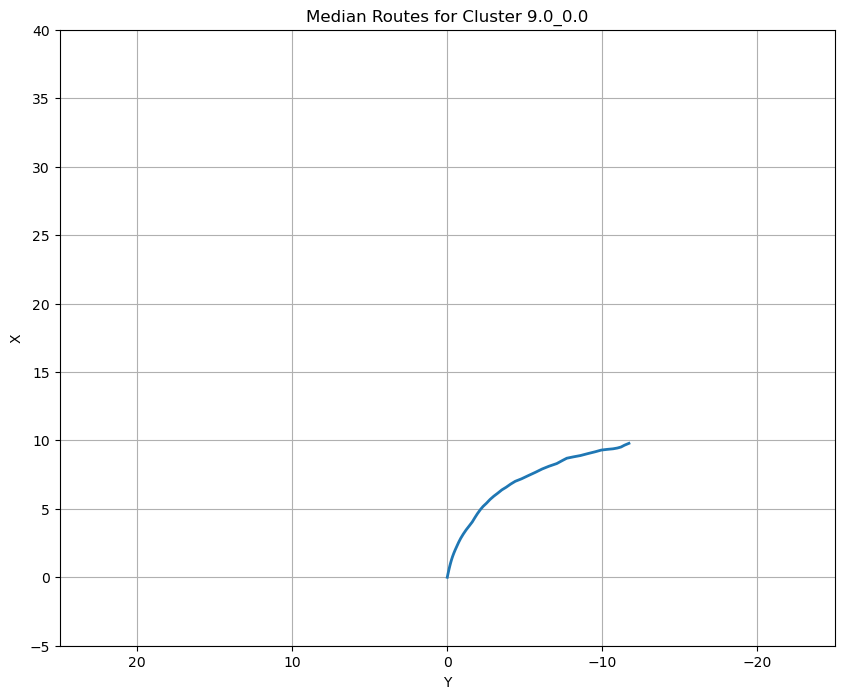

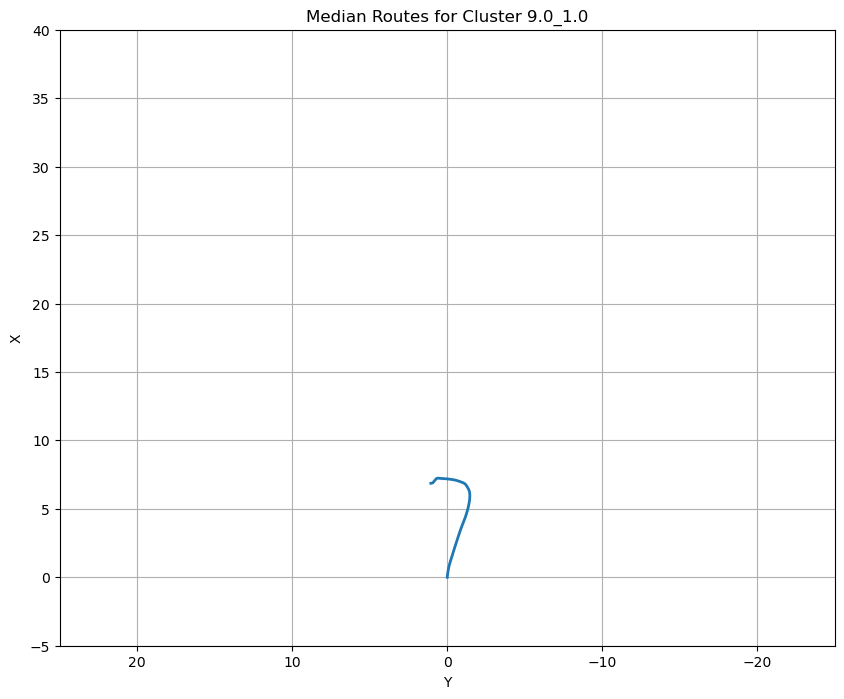

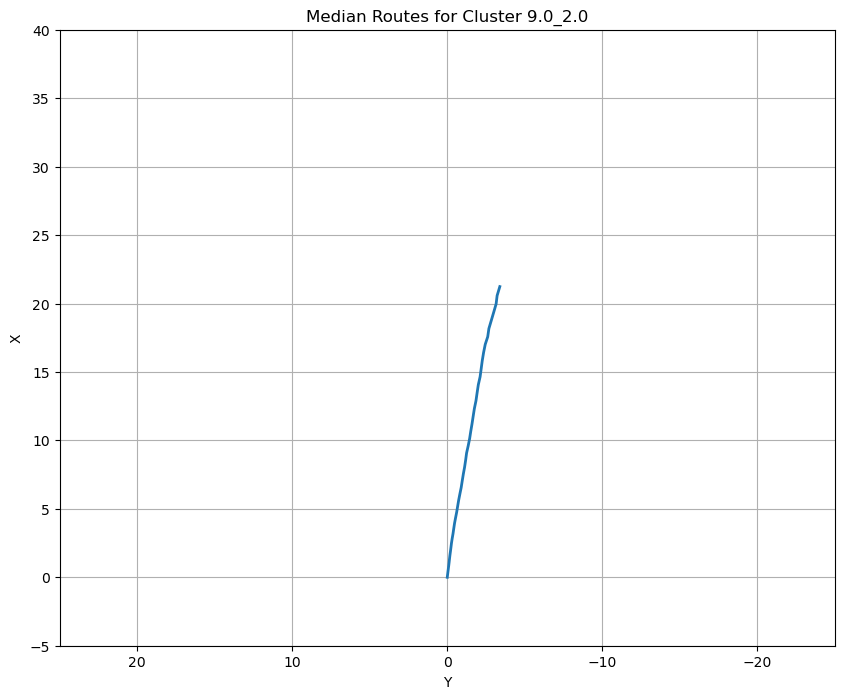

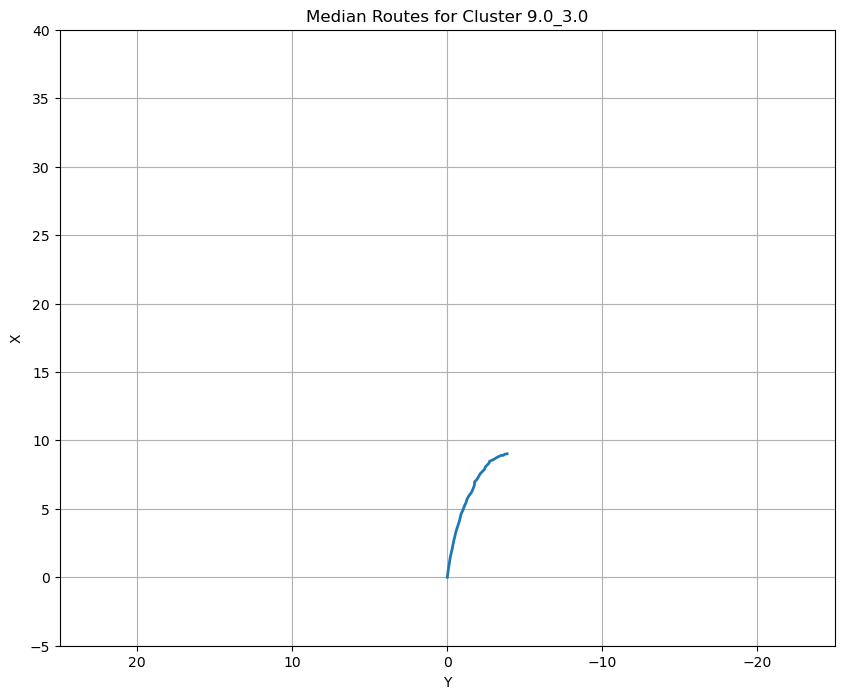

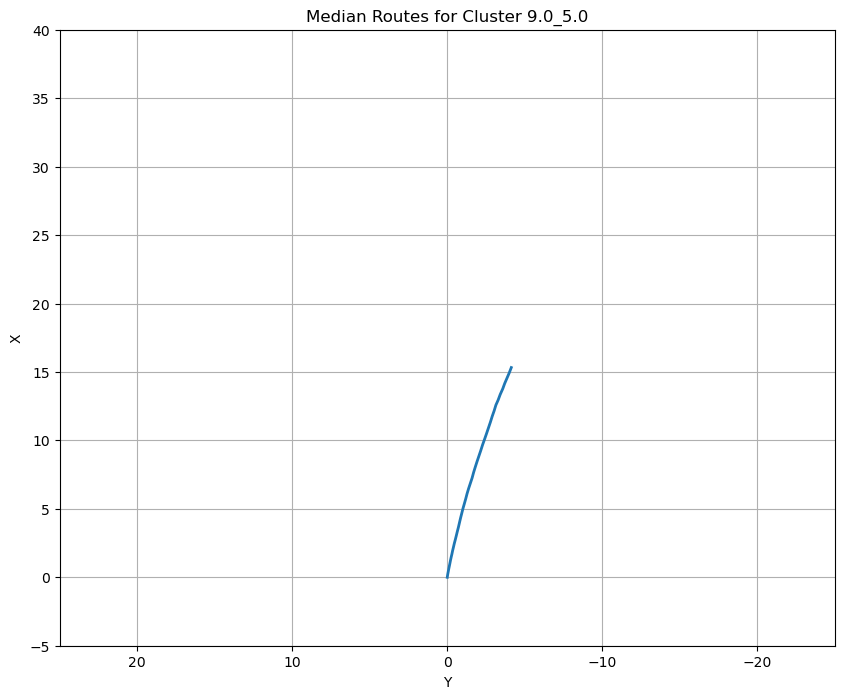

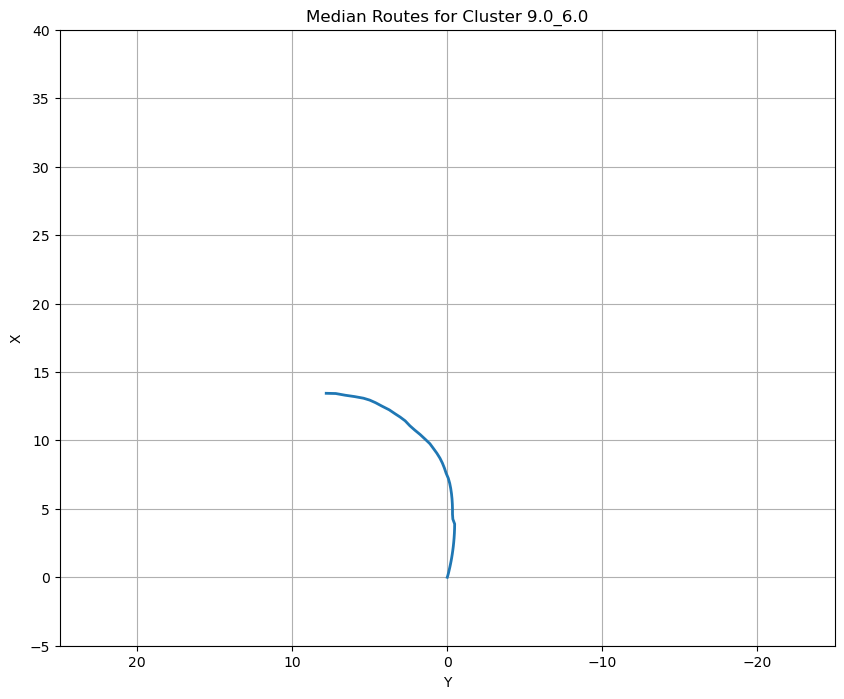

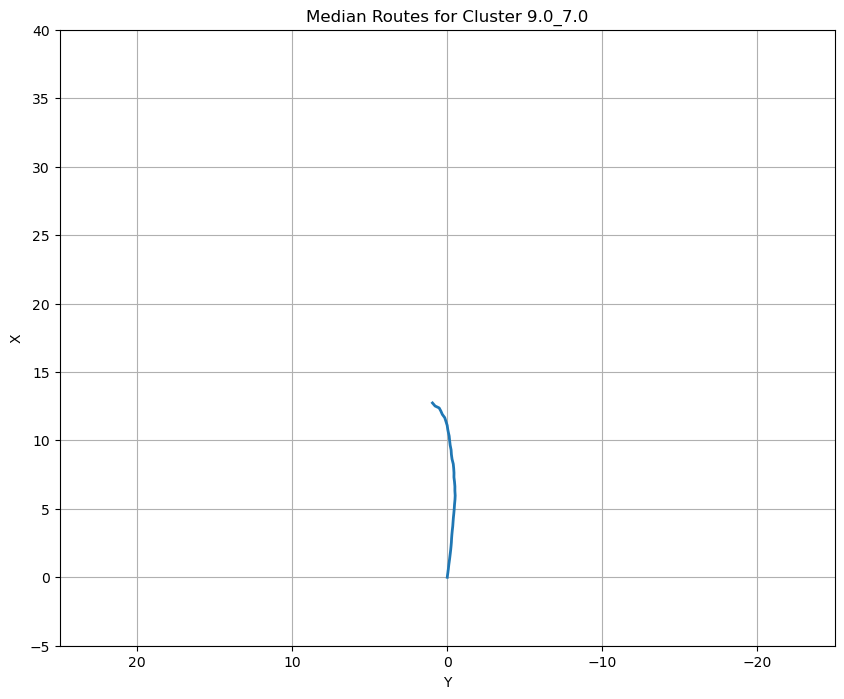

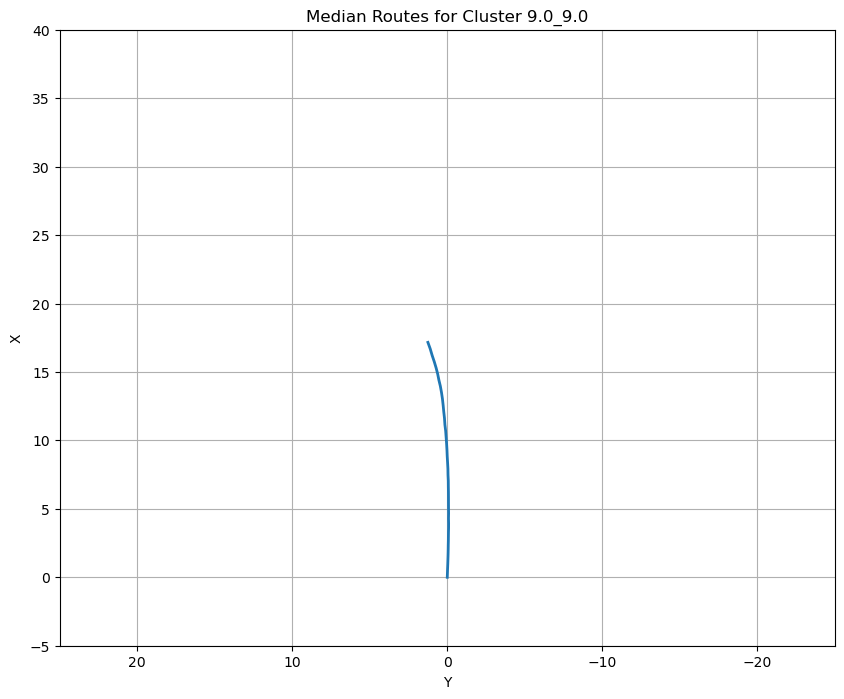

In [24]:
def plot_cluster_medians(cluster_medians):
    
    for cluster_label, (median_x, median_y) in cluster_medians.items():
        plt.figure(figsize=(10, 8))
        # if cluster_label in fade_clusters:
        #     continue
        plt.plot(median_y, median_x, label=f"Cluster {cluster_label}", linewidth=2)
        plt.title(f"Median Routes for Cluster {cluster_label}")
        plt.xlabel("Y")
        plt.ylabel("X")

        plt.ylim(-5, 40)  # Set the x-axis limits
        plt.xlim(25, -25)
        plt.grid(True)
        
        plt.show()
    
    
plot_cluster_medians(cluster_medians)

In [25]:
route_dict = {
    "0.0_0.0": "Corner",
    "0.0_1.0": "Texas",
    "0.0_3.0": "Out", #?
    "0.0_5.0": "Wheel", #?
    "0.0_7.0": "Mid", #?
    "0.0_8.0": "Flat",
    "1.0_0.0": "Out",
    "1.0_1.0": "In",
    "1.0_3.0": "Comeback",
    "1.0_4.0": "In",
    "1.0_5.0": "Go",
    "1.0_6.0": "Post",
    "1.0_7.0": "Go",
    "1.0_8.0": "Flat",
    "1.0_9.0": "Go",
    "2.0_0.0": "Corner",
    "2.0_1.0": "In",
    "2.0_2.0": "Go",
    "2.0_3.0": "Comeback",
    "2.0_5.0": "Corner",
    "2.0_6.0": "Post",
    "2.0_7.0": "Comeback",
    "2.0_9.0": "Go",
    "3.0_0.0": "Out",
    "3.0_1.0": "In",
    "3.0_3.0": "Mid",
    "3.0_4.0": "Flat",
    "3.0_5.0": "Go", #?
    "3.0_7.0": "Mid",
    "3.0_8.0": "Flat",
    "4.0_1.0": "In",
    "4.0_2.0": "Go",
    "4.0_3.0": "Out",
    "4.0_4.0": "Slant",
    "4.0_5.0": "Corner",
    "4.0_6.0": "Post",
    "4.0_7.0": "Post", #?
    "4.0_9.0": "Go", #?
    "5.0_4.0": "Flat",
    "5.0_6.0": "Wheel",
    "5.0_7.0": "Texas",
    "5.0_8.0": "Flat",
    "6.0_0.0": "Flat",
    "6.0_1.0": "Flat",
    "6.0_3.0": "Wheel",
    "6.0_4.0": "Flat",
    "6.0_8.0": "Flat",
    "7.0_1.0": "Slant",
    "7.0_3.0": "Texas",
    "7.0_4.0": "Slant",
    "7.0_6.0": "Post", #?
    "7.0_7.0": "Mid",
    "7.0_8.0": "Flat",
    "8.0_0.0": "Wheel",
    "8.0_2.0": "Wheel",
    "8.0_3.0": "Wheel",
    "8.0_5.0": "Wheel",
    "8.0_8.0": "Flat",
    "8.0_9.0": "Texas",
    "9.0_0.0": "Corner",
    "9.0_1.0": "Comeback",
    "9.0_2.0": "Go",
    "9.0_3.0": "Out",
    "9.0_5.0": "Go",
    "9.0_6.0": "In",
    "9.0_7.0": "Mid", #?
    "9.0_9.0": "Go"
}

In [29]:
combined_df = combined_df.merge(
    routes_df[['gameId', 'playId', 'nflId', 'cluster_label', 'train_test_split']],
    on=['gameId', 'playId', 'nflId'],
    how='left'
)

combined_df.head(10)

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,cluster_label,train_test_split
0,2021090900,97,41233.0,6,2021-09-10T00:26:31.600,13.0,TB,right,0.00,0.00,0.00,0.00,0.00,129.28,4.76,ball_snap,7.0_4.0,train
1,2021090900,97,41233.0,7,2021-09-10T00:26:31.700,13.0,TB,right,0.01,0.01,0.00,0.00,0.01,129.28,23.29,NaN,7.0_4.0,train
2,2021090900,97,41233.0,8,2021-09-10T00:26:31.800,13.0,TB,right,0.02,0.02,0.02,0.55,0.01,127.86,41.24,NaN,7.0_4.0,train
3,2021090900,97,41233.0,9,2021-09-10T00:26:31.900,13.0,TB,right,0.04,0.03,0.27,2.93,0.02,125.97,61.85,NaN,7.0_4.0,train
4,2021090900,97,41233.0,10,2021-09-10T00:26:32.000,13.0,TB,right,0.08,0.05,0.64,3.88,0.04,125.17,61.07,NaN,7.0_4.0,train
5,2021090900,97,41233.0,11,2021-09-10T00:26:32.100,13.0,TB,right,0.16,0.09,1.11,4.22,0.09,123.72,61.91,NaN,7.0_4.0,train
6,2021090900,97,41233.0,12,2021-09-10T00:26:32.200,13.0,TB,right,0.29,0.16,1.63,4.35,0.15,122.60,63.15,NaN,7.0_4.0,train
7,2021090900,97,41233.0,13,2021-09-10T00:26:32.300,13.0,TB,right,0.48,0.26,2.28,4.73,0.22,120.24,62.43,NaN,7.0_4.0,train
8,2021090900,97,41233.0,14,2021-09-10T00:26:32.400,13.0,TB,right,0.72,0.41,2.92,4.87,0.28,115.86,59.70,NaN,7.0_4.0,train
9,2021090900,97,41233.0,15,2021-09-10T00:26:32.500,13.0,TB,right,1.00,0.60,3.49,4.56,0.34,110.40,57.90,NaN,7.0_4.0,train


In [30]:
combined_df.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,cluster_label,train_test_split
0,2021090900,97,41233.0,6,2021-09-10T00:26:31.600,13.0,TB,right,0.00,0.00,0.00,0.00,0.00,129.28,4.76,ball_snap,7.0_4.0,train
1,2021090900,97,41233.0,7,2021-09-10T00:26:31.700,13.0,TB,right,0.01,0.01,0.00,0.00,0.01,129.28,23.29,NaN,7.0_4.0,train
2,2021090900,97,41233.0,8,2021-09-10T00:26:31.800,13.0,TB,right,0.02,0.02,0.02,0.55,0.01,127.86,41.24,NaN,7.0_4.0,train
3,2021090900,97,41233.0,9,2021-09-10T00:26:31.900,13.0,TB,right,0.04,0.03,0.27,2.93,0.02,125.97,61.85,NaN,7.0_4.0,train
4,2021090900,97,41233.0,10,2021-09-10T00:26:32.000,13.0,TB,right,0.08,0.05,0.64,3.88,0.04,125.17,61.07,NaN,7.0_4.0,train


In [31]:
combined_df['route'] = combined_df['cluster_label'].map(route_dict)

combined_df.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,cluster_label,train_test_split,route
0,2021090900,97,41233.0,6,2021-09-10T00:26:31.600,13.0,TB,right,0.00,0.00,0.00,0.00,0.00,129.28,4.76,ball_snap,7.0_4.0,train,Slant
1,2021090900,97,41233.0,7,2021-09-10T00:26:31.700,13.0,TB,right,0.01,0.01,0.00,0.00,0.01,129.28,23.29,NaN,7.0_4.0,train,Slant
2,2021090900,97,41233.0,8,2021-09-10T00:26:31.800,13.0,TB,right,0.02,0.02,0.02,0.55,0.01,127.86,41.24,NaN,7.0_4.0,train,Slant
3,2021090900,97,41233.0,9,2021-09-10T00:26:31.900,13.0,TB,right,0.04,0.03,0.27,2.93,0.02,125.97,61.85,NaN,7.0_4.0,train,Slant
4,2021090900,97,41233.0,10,2021-09-10T00:26:32.000,13.0,TB,right,0.08,0.05,0.64,3.88,0.04,125.17,61.07,NaN,7.0_4.0,train,Slant


We will now look at the Cincinnati Bengals and the Buffalo Bills to see if we can sanity check our clustering model with route distributions for different players

In [32]:
case_df = combined_df[(combined_df['team'] == 'BUF') | (combined_df['team'] == 'CIN')]

case_df.jerseyNumber.unique()

array([ 1., 11., 13., 14., 19., 26., 88., 22., 28., 83., 85., 87., 34.,
       89., 80., 84., 25., 20., 15., 41., 16., 32., 71.])

In [33]:
buf_dict = {
    "Matt Breida": 22,
    "Reggie Gilliam": 41,
    "Taiwan Jones": 25,
    "Zack Moss": 20,
    "Devin Singletary": 26,
    "Christian Wade": 45,
    "Cole Beasley": 11,
    "Gabriel Davis": 13,
    "Stefon Diggs": 14,
    "Isaiah Hodgins": 16,
    "Dawson Knox": 88,
    "Jake Kumerow": 15,
    "Isaiah McKenzie": 19,
    "Emmanuel Sanders": 1,
    "Marquez Stevenson": 5,
    "Tommy Sweeney": 89,
    "Kahale Warring": 81
}


cin_dict = {
    "Chris Evans": 25,
    "Joe Mixon": 28,
    "Samaje Perine": 34,
    "Trayveon Williams": 32,
    "Tyler Boyd": 83,
    "Ja'Marr Chase": 1,
    "Tee Higgins": 85,
    "Trenton Irwin": 16,
    "Stanley Morgan": 17,
    "Drew Sample": 89,
    "Mason Schreck": 86,
    "Auden Tate": 19,
    "Trent Taylor": 11,
    "Mike Thomas": 80,
    "C.J. Uzomah": 87,
    "Mitchell Wilcox": 84,
    "Pooka Williams": 12
}


In [38]:
diggs = case_df[(case_df['jerseyNumber'] == buf_dict.get("Stefon Diggs")) & (case_df['team'] == 'BUF')]

diggs.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,cluster_label,train_test_split,route
18006,2021091201,63,42489.0,6,2021-09-12T17:06:36.500,14.0,BUF,left,0.00,0.00,0.00,0.00,0.01,283.31,293.96,ball_snap,1.0_3.0,train,Comeback
18007,2021091201,63,42489.0,7,2021-09-12T17:06:36.600,14.0,BUF,left,0.02,0.00,0.02,0.57,0.02,282.38,268.41,NaN,1.0_3.0,train,Comeback
18008,2021091201,63,42489.0,8,2021-09-12T17:06:36.700,14.0,BUF,left,0.03,0.01,0.17,1.90,0.01,282.38,272.01,NaN,1.0_3.0,train,Comeback
18009,2021091201,63,42489.0,9,2021-09-12T17:06:36.800,14.0,BUF,left,0.07,0.02,0.48,3.07,0.04,280.57,281.58,NaN,1.0_3.0,train,Comeback
18010,2021091201,63,42489.0,10,2021-09-12T17:06:36.900,14.0,BUF,left,0.16,0.03,1.01,4.07,0.09,281.62,279.55,NaN,1.0_3.0,train,Comeback


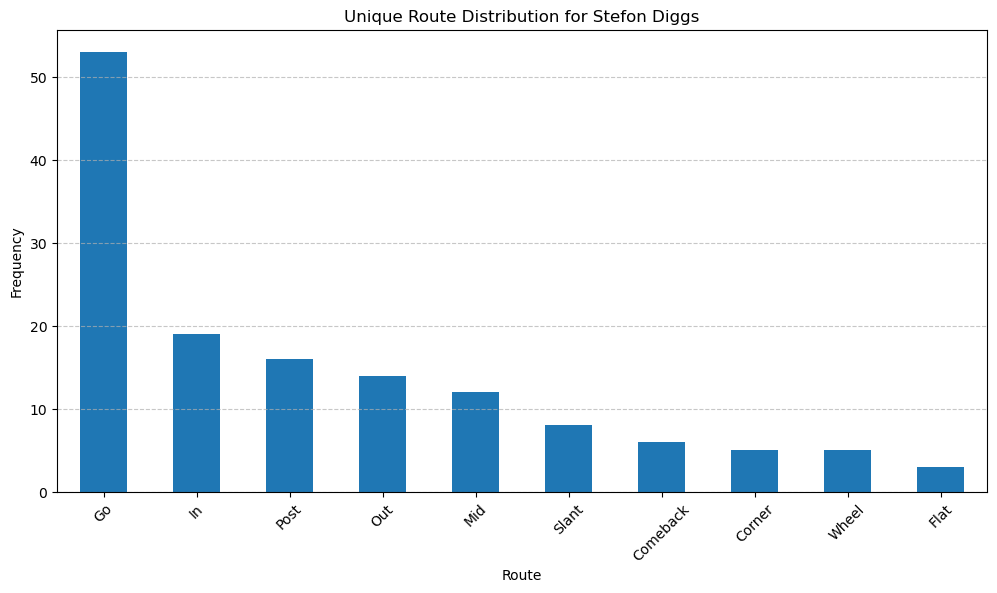

In [39]:
# Deduplicate the DataFrame to retain only one row per unique combination of gameId, playId, nflId, and route
unique_routes = diggs[['gameId', 'playId', 'nflId', 'route']].drop_duplicates()

# Count the occurrences of each route
route_distribution = unique_routes['route'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
route_distribution.sort_values(ascending=False).plot(kind='bar')
plt.title("Unique Route Distribution for Stefon Diggs")
plt.xlabel("Route")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [40]:
beasley = case_df[(case_df['jerseyNumber'] == buf_dict.get("Cole Beasley")) & (case_df['team'] == 'BUF')]

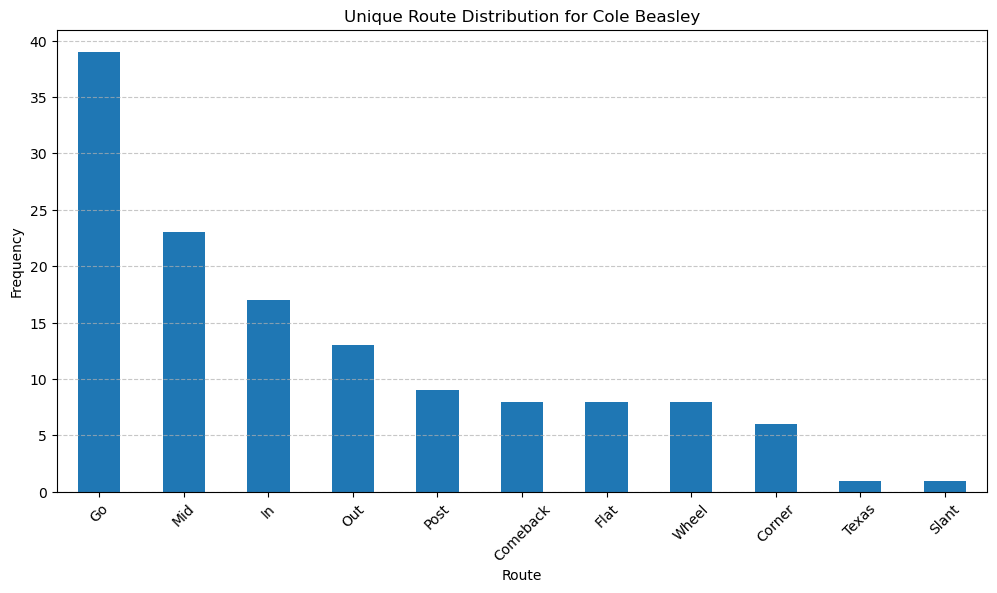

In [41]:
# Deduplicate the DataFrame to retain only one row per unique combination of gameId, playId, nflId, and route
unique_routes = beasley[['gameId', 'playId', 'nflId', 'route']].drop_duplicates()

# Count the occurrences of each route
route_distribution = unique_routes['route'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
route_distribution.sort_values(ascending=False).plot(kind='bar')
plt.title("Unique Route Distribution for Cole Beasley")
plt.xlabel("Route")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [42]:
sanders = case_df[(case_df['jerseyNumber'] == buf_dict.get("Emmanuel Sanders")) & (case_df['team'] == 'BUF')]

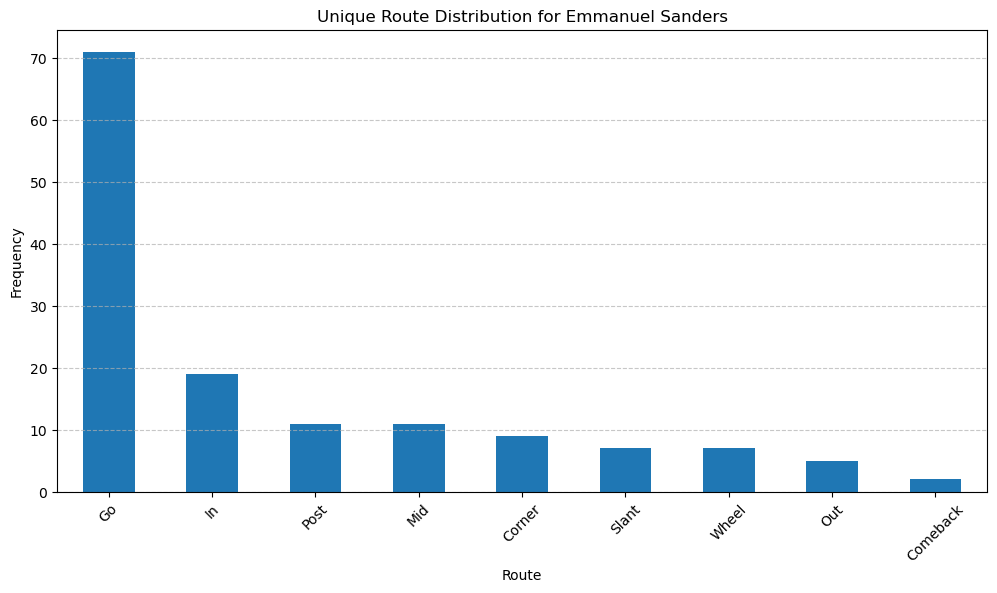

In [43]:
# Deduplicate the DataFrame to retain only one row per unique combination of gameId, playId, nflId, and route
unique_routes = sanders[['gameId', 'playId', 'nflId', 'route']].drop_duplicates()

# Count the occurrences of each route
route_distribution = unique_routes['route'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
route_distribution.sort_values(ascending=False).plot(kind='bar')
plt.title("Unique Route Distribution for Emmanuel Sanders")
plt.xlabel("Route")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [44]:
singletary = case_df[(case_df['jerseyNumber'] == buf_dict.get("Devin Singletary")) & (case_df['team'] == 'BUF')]

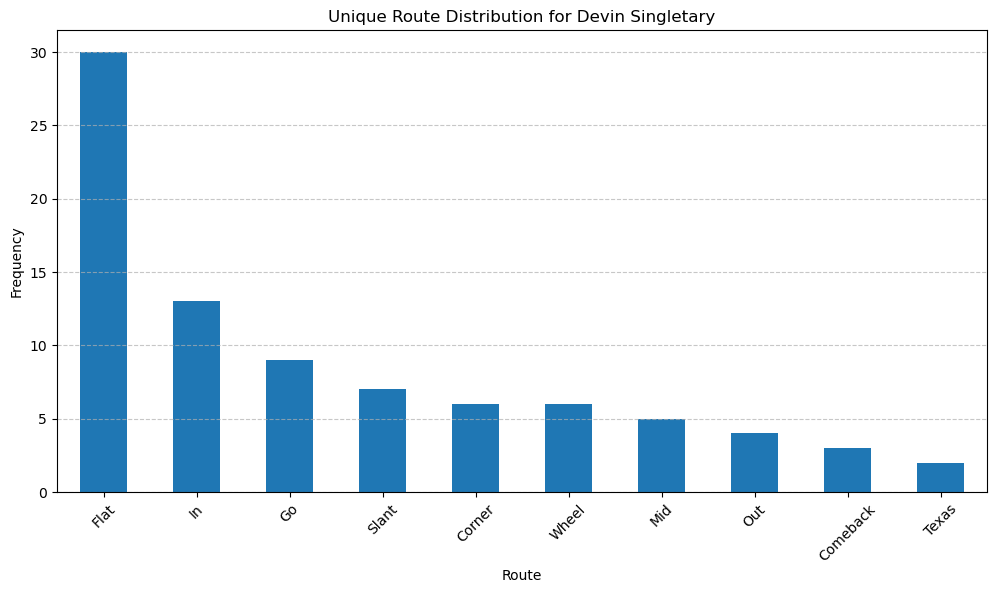

In [45]:
# Deduplicate the DataFrame to retain only one row per unique combination of gameId, playId, nflId, and route
unique_routes = singletary[['gameId', 'playId', 'nflId', 'route']].drop_duplicates()

# Count the occurrences of each route
route_distribution = unique_routes['route'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
route_distribution.sort_values(ascending=False).plot(kind='bar')
plt.title("Unique Route Distribution for Devin Singletary")
plt.xlabel("Route")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [46]:
chase = case_df[(case_df['jerseyNumber'] == cin_dict.get("Ja'Marr Chase")) & (case_df['team'] == 'CIN')]

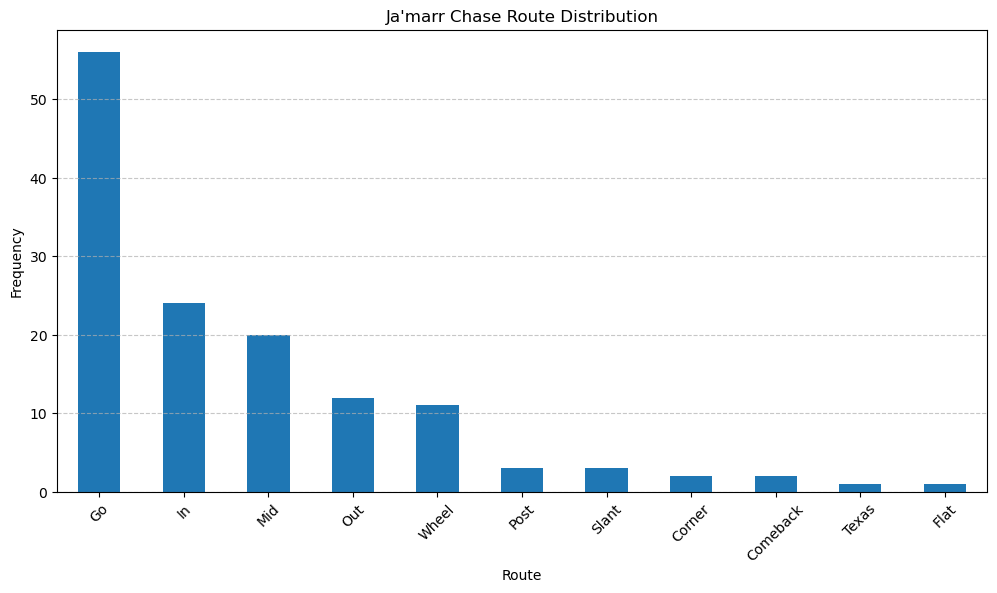

In [47]:
# Deduplicate the DataFrame to retain only one row per unique combination of gameId, playId, nflId, and route
unique_routes = chase[['gameId', 'playId', 'nflId', 'route']].drop_duplicates()

# Count the occurrences of each route
route_distribution = unique_routes['route'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
route_distribution.sort_values(ascending=False).plot(kind='bar')
plt.title("Ja'marr Chase Route Distribution")
plt.xlabel("Route")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [48]:
boyd = case_df[(case_df['jerseyNumber'] == cin_dict.get("Tyler Boyd")) & (case_df['team'] == 'CIN')]

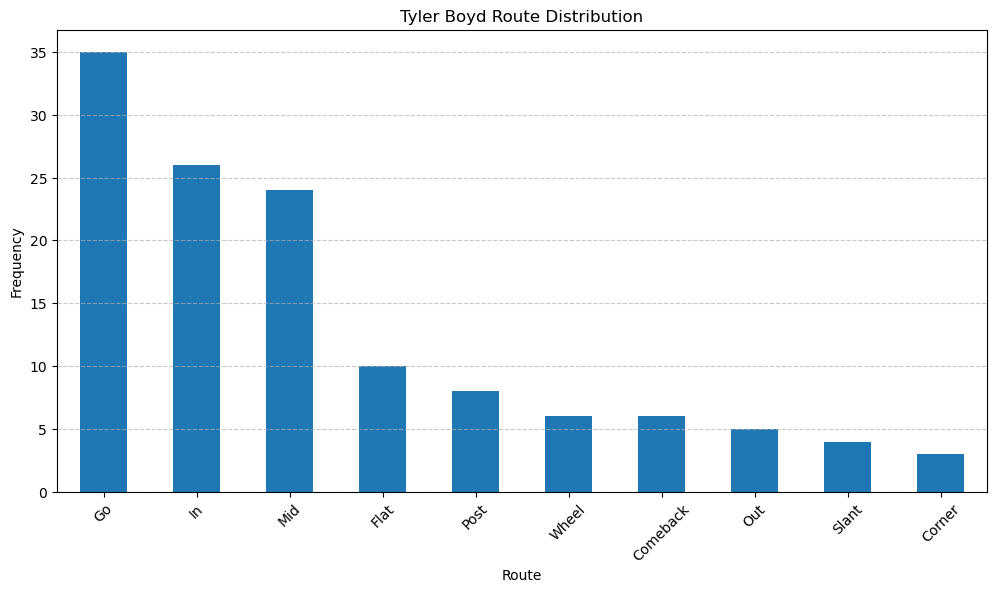

In [49]:
# Deduplicate the DataFrame to retain only one row per unique combination of gameId, playId, nflId, and route
unique_routes = boyd[['gameId', 'playId', 'nflId', 'route']].drop_duplicates()

# Count the occurrences of each route
route_distribution = unique_routes['route'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
route_distribution.sort_values(ascending=False).plot(kind='bar')
plt.title("Tyler Boyd Route Distribution")
plt.xlabel("Route")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [50]:
higgins = case_df[(case_df['jerseyNumber'] == cin_dict.get("Tee Higgins")) & (case_df['team'] == 'CIN')]

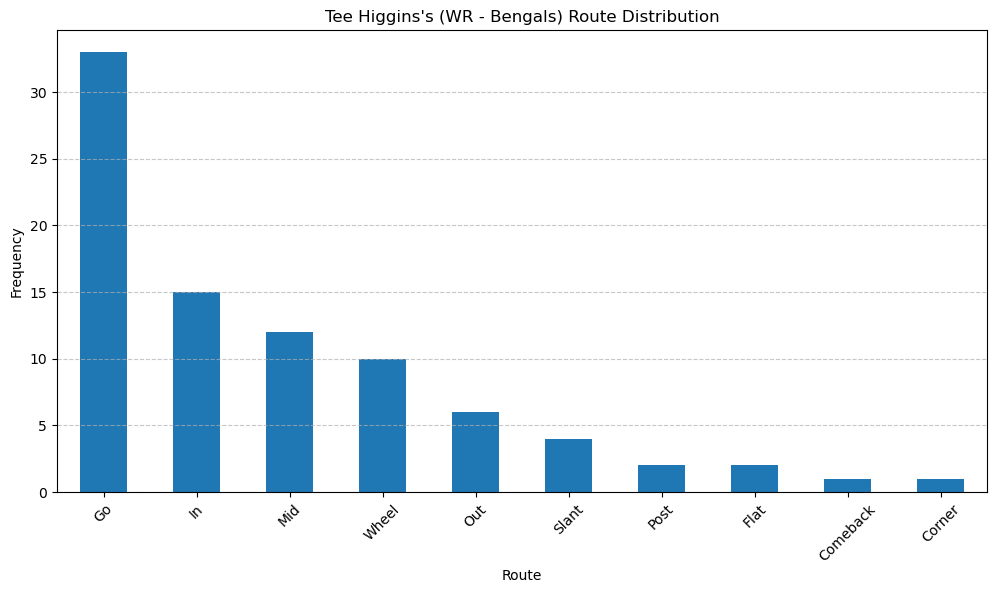

In [51]:
# Deduplicate the DataFrame to retain only one row per unique combination of gameId, playId, nflId, and route
unique_routes = higgins[['gameId', 'playId', 'nflId', 'route']].drop_duplicates()

# Count the occurrences of each route
route_distribution = unique_routes['route'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
route_distribution.sort_values(ascending=False).plot(kind='bar')
plt.title("Tee Higgins's (WR - Bengals) Route Distribution")
plt.xlabel("Route")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [52]:
mixon = case_df[(case_df['jerseyNumber'] == cin_dict.get("Joe Mixon")) & (case_df['team'] == 'CIN')]

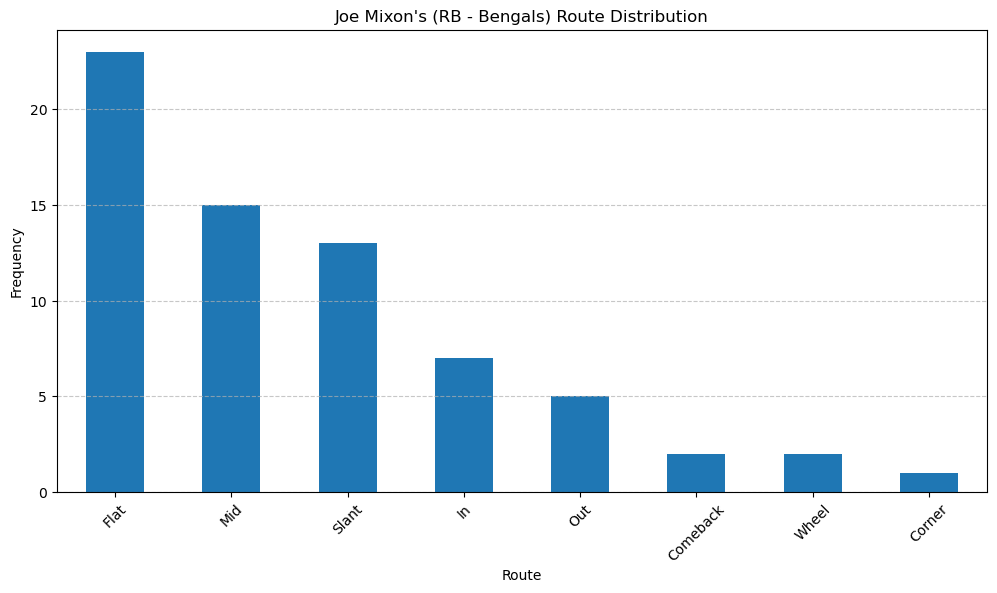

In [53]:
# Deduplicate the DataFrame to retain only one row per unique combination of gameId, playId, nflId, and route
unique_routes = mixon[['gameId', 'playId', 'nflId', 'route']].drop_duplicates()

# Count the occurrences of each route
route_distribution = unique_routes['route'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
route_distribution.sort_values(ascending=False).plot(kind='bar')
plt.title("Joe Mixon's (RB - Bengals) Route Distribution")
plt.xlabel("Route")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [54]:
top_10_te = [
    (89, "BAL"),
    (87, "KC"),
    (88, "BUF"),
    (86, "DAL"),
    (83, "LV"),
    (88, "MIA"),
    (8, "ATL"),
    (88, "DET"),
    (87, "DEN"),
    (85, "NE")
]

In [55]:
combined_df.team.unique()

array(['TB', 'DAL', 'ATL', 'PHI', 'BUF', 'PIT', 'NYJ', 'CAR', 'MIN',
       'CIN', 'DET', 'SF', 'HOU', 'JAX', 'IND', 'SEA', 'TEN', 'ARI',
       'LAC', 'WAS', 'CLE', 'KC', 'NE', 'MIA', 'NO', 'GB', 'NYG', 'DEN',
       'CHI', 'LA', 'LV', 'BAL'], dtype=object)

In [56]:
te = combined_df[combined_df[['jerseyNumber','team']].apply(tuple, axis=1).isin(top_10_te)]

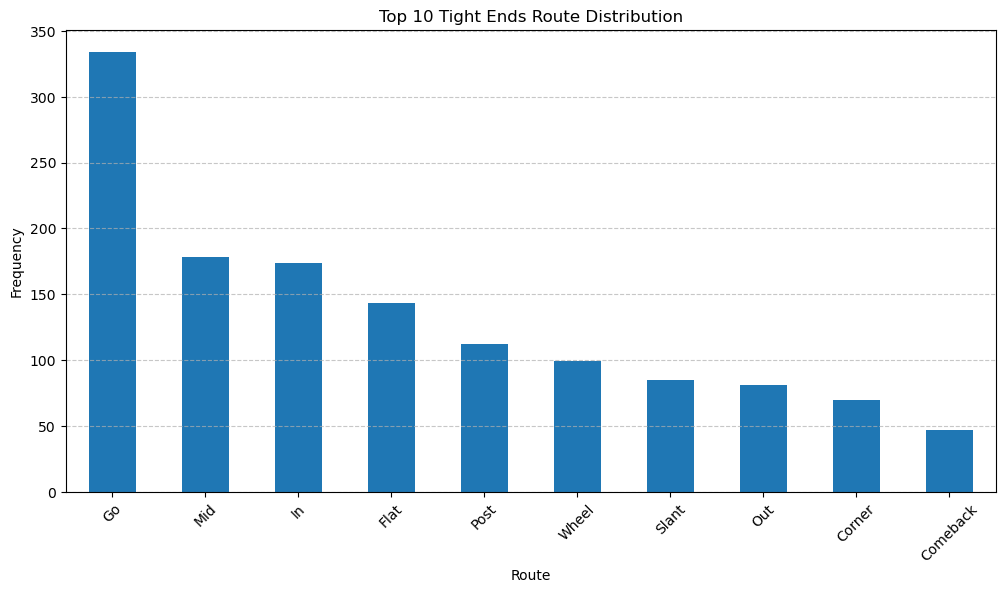

In [57]:
# Deduplicate the DataFrame to retain only one row per unique combination of gameId, playId, nflId, and route
unique_routes = te[['gameId', 'playId', 'nflId', 'route']].drop_duplicates()

# Count the occurrences of each route
route_distribution = unique_routes['route'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
route_distribution.sort_values(ascending=False).plot(kind='bar')
plt.title("Top 10 Tight Ends Route Distribution")
plt.xlabel("Route")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [58]:
top_10_wr = [
    (17, "GB"),
    (14, "BUF"),
    (10, "ARI"),
    (10, "KC"),
    (12, "CHI"),
    (11, "TEN"),
    (18, "MIN"),
    (13, "NO"),
    (2, "TEN"),
    (18, "ATL")
]

In [59]:
wr = combined_df[combined_df[['jerseyNumber','team']].apply(tuple, axis=1).isin(top_10_wr)]

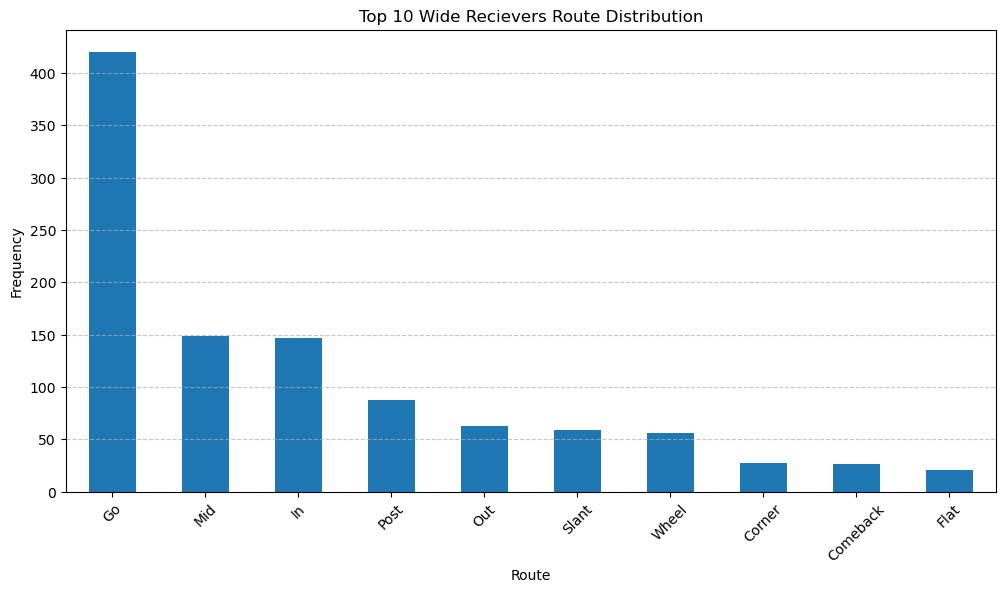

In [60]:
# Deduplicate the DataFrame to retain only one row per unique combination of gameId, playId, nflId, and route
unique_routes = wr[['gameId', 'playId', 'nflId', 'route']].drop_duplicates()

# Count the occurrences of each route
route_distribution = unique_routes['route'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
route_distribution.sort_values(ascending=False).plot(kind='bar')
plt.title("Top 10 Wide Recievers Route Distribution")
plt.xlabel("Route")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [61]:
top_10_rb = [
    (22, "TEN"),
    (33, "MIN"),
    (22, "CAR"),
    (24, "CLE"),
    (41, "NO"),
    (33, "GB"),
    (26, "NYG"),
    (32, "SEA"),
    (28, "LV"),
    (27, "CLE")
]

In [62]:
rb = combined_df[combined_df[['jerseyNumber','team']].apply(tuple, axis=1).isin(top_10_rb)]

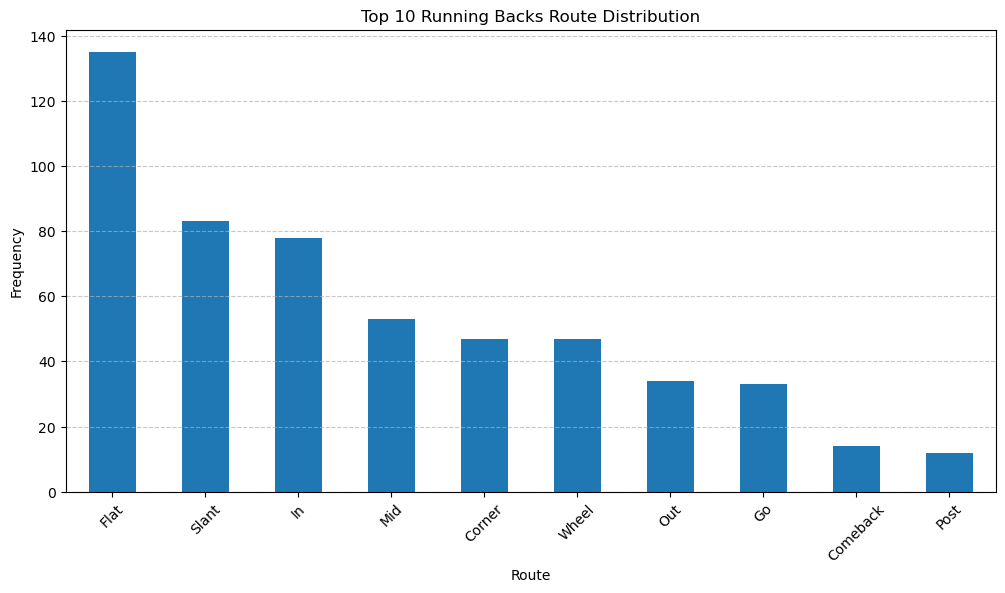

In [63]:
# Deduplicate the DataFrame to retain only one row per unique combination of gameId, playId, nflId, and route
unique_routes = rb[['gameId', 'playId', 'nflId', 'route']].drop_duplicates()

# Count the occurrences of each route
route_distribution = unique_routes['route'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
route_distribution.sort_values(ascending=False).plot(kind='bar')
plt.title("Top 10 Running Backs Route Distribution")
plt.xlabel("Route")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [64]:
combined_df.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,cluster_label,train_test_split,route
0,2021090900,97,41233.0,6,2021-09-10T00:26:31.600,13.0,TB,right,0.00,0.00,0.00,0.00,0.00,129.28,4.76,ball_snap,7.0_4.0,train,Slant
1,2021090900,97,41233.0,7,2021-09-10T00:26:31.700,13.0,TB,right,0.01,0.01,0.00,0.00,0.01,129.28,23.29,NaN,7.0_4.0,train,Slant
2,2021090900,97,41233.0,8,2021-09-10T00:26:31.800,13.0,TB,right,0.02,0.02,0.02,0.55,0.01,127.86,41.24,NaN,7.0_4.0,train,Slant
3,2021090900,97,41233.0,9,2021-09-10T00:26:31.900,13.0,TB,right,0.04,0.03,0.27,2.93,0.02,125.97,61.85,NaN,7.0_4.0,train,Slant
4,2021090900,97,41233.0,10,2021-09-10T00:26:32.000,13.0,TB,right,0.08,0.05,0.64,3.88,0.04,125.17,61.07,NaN,7.0_4.0,train,Slant


In [65]:
routes_df.head()

,gameId,playId,nflId,bezier_curve,final_pos,train_test_split,curve_cluster,position_cluster,cluster_label
0,2021090900,97,35481.0,"[0.0, -0.0, 0.10591385392385956, -0.0864401776...","(5.840000000000003, -16.37)",train,8.0,0.0,8.0_0.0
1,2021090900,97,35634.0,"[0.0, -0.0, 0.11257039761130107, -0.0940826796...","(14.009999999999998, -3.629999999999995)",train,9.0,5.0,9.0_5.0
2,2021090900,97,39985.0,"[0.0, 0.0, 0.016995940210599105, 0.01983417802...","(0.7100000000000009, -8.12)",train,6.0,8.0,6.0_8.0
3,2021090900,97,41233.0,"[0.0, 0.0, 0.03139033275379332, 0.018729531964...","(4.910000000000004, 16.790000000000003)",train,7.0,4.0,7.0_4.0
4,2021090900,97,44896.0,"[0.0, 0.0, 0.11400586146724184, 0.169068676925...","(13.990000000000002, 14.600000000000003)",train,4.0,6.0,4.0_6.0


In [66]:
combined_df.to_csv('./data/labeled_pos_data.csv')
routes_df.to_csv('./data/labeled_routes.csv')